# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## Asignación de vuelos a gates en aeropuerto

Esta  notebook implementa un algoritmo genético monoobjetivo para la resolución de la asignación de vuelos a gates. Los operadores de cruzamiento y mutación NO aseguran que los individuos representen vuelos diferentes y gates diferentes.

#### Representacion de Individuo:

Un objeto Individual representaa una determinada asignacion de un subconjunto de vuelos (almacenado en <b>list_of_flights</b>) a un conjunto de gates (almacenado en <b>chromosome</b>). La lista de gates disponibles que se pueden asignar a los vuelos se almacena en la variable <b>allele_pool</b>  del individuo. Ver el siguiente grafico ilustrativo:

<img src="EjemploIndividuoAvion.jpg">



In [1]:
import sys
import time
import numpy as np
import random
from random import seed, randint, sample, uniform, randrange
from copy import deepcopy
import matplotlib.pyplot as plt

### Clase <b>Individual</b>

Esta es una clase para definir a un individuo de la población. Cada individuo posee un cromosoma, los vuelos a asignar, todos los posibles alelos y su respectivo fitness. Además, los métodos de esta clase permiten realizar el cruzamiento (crossover) y la mutación (mutation) sobre el cromosoma del individuo.

In [2]:
# Clase que implementa el individuo y sus operadores
class Individual(object):
    
    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):  
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.gates))  # escoge aleatoriamento una posicion en la lista gates
        ind1 = Individual(self.flights, self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []
        gates_ind2 = []
        
        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
                gates_ind1.append(self.gates[i])
                gates_ind2.append(other.gates[i])
            else:
                gates_ind1.append(other.gates[i])
                gates_ind2.append(self.gates[i])
        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def mutate_position(self):
        "Cambia aleatoriamente el Gate asignado a un Flight."
        mutated_gates = deepcopy(self.gates)
        indexGate = randrange(0, len(self.gates)) # escoje el indice del elemento de gates que sera mutado
        newGate = self.gates_pool[randrange(0, len(self.gates_pool))]
        mutated_gates[indexGate] = newGate
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

### Clase <b>Gate</b>

Esta es una clase abstracta para definir los lugares donde los vuelos serán asignados. Se debe hacer subclases con el fin de diferenciar los tipos de lugar donde un vuelo puede ser asignado.

In [3]:
class Gate(object):
    def __init__(self, identifier, x, y, z):
        self.identifier = identifier   # identificador del Gate
        self.distance = x              # en el caso de Sleeve esto almacena la longitud de manga. En el caso de zonas es la distancia a una puerta del aeropuerto 
        self.potential_of_speed = y    # en el caso de Sleeve esto almacena la velocidad de pasajeros en manga. En el caso de zona almacena la velocidad del bus 
        self.number_of_persons_every_10m = z   # en el caso de Sleeve esto almacena el numero de personas cada 10 metros. En el cazo de zona es la capacidad del bus
  
    def __hash__(self):
        return self.identifier

### Clase <b>Sleeve</b>

Esta clase implementa concretamente el Gate tipo Sleeve (Manga). En este tipo de gate, los pasajeros deben realizar un recorrido a pie hasta abandonar totalmente el Gate. Se tiene en cuenta la longitud de la manga, la velocidad de los pasajeros y la cantidad de personas que pueden estar cada 10m (este valor es variable porque ya refleja el ancho de la manga, puesto que una manga más ancha permite una mayor cantidad de pasajeros).

In [4]:
class Sleeve(Gate):
    def __init__(self, identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m):
        super().__init__(identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m)

### Clase <b>Zone</b>

Esta clase implementa concretamente el Gate tipo Zone (zona). En este tipo de gate, los pasajeros son recogidos por un bus y son llevados hasta una puerta. Se tiene en cuenta la distancia de la zona a la puerta, la velocidad y capacidad del bus.

In [5]:
class Zone(Gate):
    def __init__(self, identifier, distance_zone_door, speed_bus, capacity_of_bus):
        super().__init__(identifier, distance_zone_door, speed_bus, capacity_of_bus)

### Clase <b>Flight</b>

Esta es una clase para definir a los vuelos a asignar. Cada vuelo posee una capacidad máxima, la cantidad de pasajeros, el tiempo de estacionamiento que le toma al vuelo, la longitud de las alas del avión, el tiempo de inspección al avión luego de aterrizar, el tiempo que demorarían en bajar las escaleras los pasajeros si el avión estuviera repleto, el momento de llegada al aeropuerto y el momento en que debería irse del aeropuerto.

In [6]:
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs  
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto
  
    def __hash__(self):
        return self.identifier

### Funciones utilitarias para generar los Gates y Vuelos</b>
Estas son funciones utilitarias para generar automáticamente los Gates y Vuelos

In [7]:
# Genera una lista de Gates
def generate_list_of_gates(number_of_gates, max_length_of_sleeve=20, max_speed_of_passengers_on_sleeve=3, max_number_of_passengers_every_10m=12, max_distance_zone_door=50, max_speed_bus=15, max_capacity_of_bus=200):
  list_of_gates = list()

  for gate_identifier in range(number_of_gates):
    gate_type = randint(0, 1)

    if gate_type == 0:   # caso manga
      distance = randint(1, max_length_of_sleeve)
      potential_of_speed = randint(1, max_speed_of_passengers_on_sleeve)
      number_of_persons_every_10m = randint(1, max_number_of_passengers_every_10m)

      gate = Sleeve(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
   
    else:    # caso zone
      distance = randint(1, max_distance_zone_door)
      potential_of_speed = randint(1, max_speed_bus)
      number_of_persons_every_10m = randint(1, max_capacity_of_bus)

      gate = Zone(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
    
    list_of_gates.append(gate)
  
  return list_of_gates

# Genera una lista de Flights
def generate_list_of_flights(number_of_flights, max_maximum_capacity=100, max_number_of_passengers_factor=0.8, max_parking_time=30, max_length_wings=25, max_inspection_time=180, max_landing_time_on_stairs=60, max_arriving_time=200, max_leaving_time=1000):
  list_of_flights = list()

  max_number_of_passengers = max_number_of_passengers_factor * max_maximum_capacity

  for flight_identifier in range(number_of_flights):
    maximum_capacity = randint(max_number_of_passengers, max_maximum_capacity)
    number_of_passengers = randint(1, max_number_of_passengers)
    parking_time = randint(1, max_parking_time)
    length_wings = randint(1, max_length_wings)
    inspection_time = randint(1, max_inspection_time)
    landing_time_on_stairs = randint(1, max_landing_time_on_stairs)
    arriving_time = randint(1, max_arriving_time)
    leaving_time = randint(max_arriving_time + 1, max_leaving_time)

    flight = Flight(flight_identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time)
    
    list_of_flights.append(flight)
  
  return list_of_flights

### Funciones utilitarias para ordenar los Vuelos y Gates</b>
Estas son funciones utilitarias para ordenar los Vuelos acorde a su deseabilidad y los Gates por su flujo personas

In [8]:
# Funcion para ordenar vuelos por su grado de deseabilidad  ( nro_pasajeros/tiempo_en_aeropuerto )
def process_desirability(n):
  return n.number_of_passengers / (n.leaving_time - n.arriving_time)

# Funcion para ordenar Gates por su capacidad de flujo de personas  
def process_flow(n):
  return n.number_of_persons_every_10m * n.potential_of_speed * 10 / n.distance

### Funciones utilitarias para el Algoritmo Genético</b>
Estas son funciones utilitarias para realizar el Algoritmo Genético que se encargue de la asignación de vuelos

In [9]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo
    
    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [10]:
# Evalua una individuo representado por sus listas:  flights, gates
def get_fitness(flights, gates):
  grace_time = 5/100
  cumulative_efficiency = 0
  gate_usage_count = {}

  for flight, gate in zip(flights, gates):
      # Contar el uso de cada gate para penalización posterior
      if gate not in gate_usage_count:
          gate_usage_count[gate] = 0
      gate_usage_count[gate] += 1

      # Cálculo de tiempo de desembarco
      number_of_passengers = flight.number_of_passengers
      if isinstance(gate, Sleeve):
          disembarkation_time_of_passengers = ((number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) + flight.parking_time + flight.inspection_time) * (1 + grace_time)
      else:
          disembarkation_time_of_passengers = ((number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) + flight.inspection_time) * (1 + grace_time)
      
      cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers

  # Penalización por uso repetido de gates
  penalty_for_repeated_gate_use = sum((count - 1) ** 2 for count in gate_usage_count.values() if count > 1)

  # La eficiencia total menos las penalizaciones
  return cumulative_efficiency - penalty_for_repeated_gate_use


In [11]:
# Evaluar la población con la función fitness
def evaluate_population(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_fn(population[i].flights, population[i].gates)

  

In [12]:
# Selección de padres por el método roulette
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [13]:
# Selección de padres por el método de torneo
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

In [14]:
# Selección de la nueva población con metodo de ranking
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    survivors = sorted(population, key=lambda x: x.fitness, reverse=True)[:numsurvivors]
    next_population.extend(survivors)
    return next_population

### Algoritmo Genético

In [15]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, 
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
  #seed(0)

  #Inicializa una poblacion inicial de forma aleatoria
  population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

  population_size = len(population)
  evaluate_population(population, fitness_fn)

  best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
  bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo  
  print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))
  
  for g in range(n_generations): # ciclo evolutivo
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
      if selection_fn == "roulette":
        mating_pool.append(select_parents_roulette(population))
      elif selection_fn == "tournament":
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
      else:
        raise NotImplementedError

    ## Crea la poblacion descendencia cruzando las parejas del mating pool     
    offspring_population = []
    for i in range(len(mating_pool)):
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      else:
        raise NotImplementedError
    
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        else:
          raise NotImplementedError  

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness_fn)
    
    ## Selecciona individuos para la sgte. generación con el metodo de ranking
    population = select_survivors_ranking(population, offspring_population, population_size) #metodo de ranking

    ## Almacena la historia del fitness del mejor individuo
    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
    bestfitness.append(best_ind.fitness)
        
    if (g % 10 == 0):  # muestra resultados cada 10 generaciones
      print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))
        
  return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen    

### Funciones utilitarias para manejar la solución del Algoritmo Genético</b>
Esta es una función utilitarias que permite mostrar la configuración usada en el Algoritmo Genético y la asignación de Vuelos a Gates encontrada en un individuo pasado (ind)

In [16]:
def make_solution_report(ind, selection_fn, crossover, mutation):
  print("Selection: {} - Crossover: {} - Mutation: {} - Fitness: {}".format(selection_fn, crossover, mutation, ind.fitness), flush=True)
  print(" - ".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(ind.flights, ind.gates)]) + "\n", flush=True)

# <b>Resolución del problema</b> 

## <b>Pasos</b>

<b>Bloque A</b>
________
1. Implementar nuevos operadores de cruzamiento y mutación que aseguran que los
individuos representen vuelos diferentes y gates diferentes.
2. Los elementos heredables en los operadores de cruzamiento deberían ser las asignaciones
flight-gate
3. La mutacion debería ser en los niveles de flights y de gates
4. Genere 30 vuelos y 10 gates

<b>Bloque B</b>
_________
5. Con los flights y gates generados en 4) elaborar experimentos para evaluar el AG con los
operadores implementados (deshabilitar mutación para ello) y luego con la mutación
habilitada a diferentes tasas de mutación. Para cada configuración a evaluar se debe hacer
al menos 10 corridas para sacar conclusiones estadísticamente válidas. Comparar contra la
implementación del código base

## <b>Bloque A</b> 

Se importan las librerías, inicializan las variables, y funciones 

In [17]:
# Librerias
import pandas as pd

In [18]:
# Variables
rows = []

## <b>Paso 1 y 2</b>

In [19]:
# Clase que implementa el individuo y sus operadores
class Individual(object):
    
    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):  
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.gates))  # escoge aleatoriamento una posicion en la lista gates
        ind1 = Individual(self.flights, self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []
        gates_ind2 = []
        
        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
                gates_ind1.append(self.gates[i])
                gates_ind2.append(other.gates[i])
            else:
                gates_ind1.append(other.gates[i])
                gates_ind2.append(self.gates[i])
        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def mutate_position(self):
        # Asegúrate de que self.gates es una lista para que se pueda modificar
        mutated_gates = list(self.gates)
        
        # Realiza la mutación
        indexGate = randrange(len(mutated_gates))
        newGate = random.choice([gate for gate in self.gates_pool if gate != mutated_gates[indexGate]])
        mutated_gates[indexGate] = newGate
        
        # Retorna una nueva instancia de Individual con la mutación aplicada
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

    ##---------------------- Paso 1 ----------------------##
    def mutation_flip(self):
        """
        Cambia aleatoriamente el Gate asignado a un Flight. Esta función ahora seleccionará un gate
        de la piscina de gates y lo asignará a un vuelo aleatorio.
        """
        # Realizar una copia profunda para evitar modificar el original
        mutated_gates = deepcopy(self.gates)
        
        # Escoger aleatoriamente el índice del gate a mutar
        indexGate = randrange(len(mutated_gates))
        
        # Seleccionar un nuevo gate aleatorio de la piscina que no sea el actual
        available_gates = [gate for gate in self.gates_pool if gate != mutated_gates[indexGate]]
        mutated_gates[indexGate] = sample(available_gates, 1)[0]
        
        # Devolver un nuevo individuo con los gates mutados
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)


    def crossover_orderpermutation(self, other):
        """Modified uniform order-based crossover that increases diversity."""
        # Escoger aleatoriamente la mitad de las posiciones del cromosoma
        pos_constantes_self = random.sample(range(len(self.flights)), len(self.flights) // 2)
        pos_constantes_other = random.sample(range(len(other.flights)), len(other.flights) // 2)
        
        # Crear cromosomas hijos inicialmente vacíos
        cromosoma1 = [-1] * len(self.flights)
        cromosoma2 = [-1] * len(other.flights)

        # Copiar las posiciones constantes de self a ind1 y de other a ind2
        for index in pos_constantes_self:
            cromosoma1[index] = self.flights[index]
        for index in pos_constantes_other:
            cromosoma2[index] = other.flights[index]

        # Llenar los espacios vacíos con vuelos del otro padre que aún no estén en el cromosoma
        # Se prioriza el orden del otro padre para mantener la permutación
        next_fill_index1 = next((i for i, x in enumerate(cromosoma1) if x == -1), None)
        next_fill_index2 = next((i for i, x in enumerate(cromosoma2) if x == -1), None)

        for flight in other.flights:
            if flight not in cromosoma1 and next_fill_index1 is not None:
                cromosoma1[next_fill_index1] = flight
                next_fill_index1 = next((i for i, x in enumerate(cromosoma1) if x == -1), None)

        for flight in self.flights:
            if flight not in cromosoma2 and next_fill_index2 is not None:
                cromosoma2[next_fill_index2] = flight
                next_fill_index2 = next((i for i, x in enumerate(cromosoma2) if x == -1), None)

        # Crear los individuos con los cromosomas hijos
        ind1 = Individual(cromosoma1, self.gates, self.flights_pool, self.gates_pool)
        ind2 = Individual(cromosoma2, other.gates, other.flights_pool, other.gates_pool)

        return [ind1, ind2]

    
     
    def mutation_swap(self):
        mutated_gates = list(self.gates)  # Convirtiendo a lista si originalmente es una tupla

        # Determina el número de swaps basado en un porcentaje del tamaño de los gates
        num_swaps = max(1, int(len(mutated_gates) * random.uniform(0.1, 0.3)))  # Entre el 10% y el 30% del tamaño

        for _ in range(num_swaps):
            # Escoge dos índices diferentes al azar en la lista de gates
            mutGen1, mutGen2 = randrange(len(mutated_gates)), randrange(len(mutated_gates))
            while mutGen1 == mutGen2:  # Asegúrate de que no son el mismo índice
                mutGen2 = randrange(len(mutated_gates))

            # Intercambia los valores de los dos índices seleccionados
            mutated_gates[mutGen1], mutated_gates[mutGen2] = mutated_gates[mutGen2], mutated_gates[mutGen1]

        # Retorna un nuevo individuo con los gates mutados
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)


### <b>Probando el Algoritmo Genético</b>
#### <b>Generación de Gates y Vuelos</b> 

Genera los Gates y Vuelos para que el Algoritmo Genético  realize la asignacion. Asegura que el numero de vuelos a asignar (**flights_to_assign**) no sea mayor a la cantidad de puertas 

### Init Population

In [20]:
##---------------------- Paso 1 ----------------------##
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
    population = []
    for _ in range(population_number):
        # Asegúrate de que hay suficientes vuelos y puertas para asignar
        if flights_to_assign > len(list_of_flights) or flights_to_assign > len(list_of_gates):
            raise ValueError("No hay suficientes vuelos o puertas para asignar a cada individuo.")

        # Selecciona aleatoriamente los vuelos para el individuo
        flights = sample(list_of_flights, flights_to_assign)

        # Selecciona aleatoriamente las puertas para el individuo sin repetir ninguna
        gates = sample(list_of_gates, flights_to_assign)

        # Crea un nuevo individuo con las listas de vuelos y puertas seleccionadas
        individual = Individual(flights, gates, list_of_flights, list_of_gates)
        population.append(individual)

    return population


## <b>Paso 3</b>

### Algoritmo genético

In [21]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, 
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
  #seed(0)

  #Inicializa una poblacion inicial de forma aleatoria
  population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

  population_size = len(population)
  evaluate_population(population, fitness_fn)

  best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
  bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo  
  print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))
  
  for g in range(n_generations): # ciclo evolutivo
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
      if selection_fn == "roulette":
        mating_pool.append(select_parents_roulette(population))
      elif selection_fn == "tournament":
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
      else:
        raise NotImplementedError
    ##---------------------- Paso 3 ----------------------##
    ## Crea la poblacion descendencia cruzando las parejas del mating pool     
    offspring_population = []
    for i in range(len(mating_pool)):
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      elif crossover == "crossover_orderpermutation":
        offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
      else:
        raise NotImplementedError
    
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        elif mutation == "inversion":
          offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
        elif mutation == "flip":
          offspring_population[i] = offspring_population[i].mutation_flip() # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
        elif mutation == "swap":
          offspring_population[i] = offspring_population[i].mutation_swap() # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
        else:
          raise NotImplementedError  

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness_fn)
    
    ## Selecciona individuos para la sgte. generación con el metodo de ranking
    population = select_survivors_ranking(population, offspring_population, population_size) #metodo de ranking

    ## Almacena la historia del fitness del mejor individuo
    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
    bestfitness.append(best_ind.fitness)
        
    if (g % 10 == 0):  # muestra resultados cada 10 generaciones
      print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))
        
  return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen    

## <b>Paso 4</b>

In [22]:
seed(0)

##---------------------- Paso 4 ----------------------##
number_of_gates = 10
number_of_flights = 30

# general los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# obtiene el numero de vuelos que el algoritmo genetico puede asignar (no puede ser mayor al numero de gates disponibles) 
flights_to_assign = number_of_flights if number_of_flights <= number_of_gates	else number_of_gates

# ordena los vuelos por su deseabilidad y los gates por su capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)


In [23]:
# Funcion de experimentacion
def experimentacion(tag, selection_fn="roulette", crossover="uniform", mutation = "position", p_mut = 0.7, reps = 10):

    num_individuals = 50

    fitness_fn = get_fitness
    n_generations = 50

    best_fitness = 0
    

    for _ in range(0,reps):
        # Realiza la asignacion con el algoritmo genetico
        best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)

        # muestra la evolucion del mejor fitness
        plt.plot(bestfitness)
        plt.show()
        make_solution_report(best_ind,selection_fn,crossover,mutation)
        asignaciones = " - ".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(best_ind.flights, best_ind.gates)])
        # imprime la mejor solucion
        rows.append({"Tag": tag,"Fitness": best_ind.fitness, "Selection":selection_fn, "Crossover":crossover, "Mutation":mutation, "Pmut":p_mut, "Asignacion": asignaciones})


## <b>Paso 5</b>

### Código con crossover uniform y mutation position

Poblacion inicial, best_fitness = 3.544561112646607
generacion 0, (Mejor fitness = 3.544561112646607)
generacion 10, (Mejor fitness = 3.544561112646607)
generacion 20, (Mejor fitness = 3.544561112646607)
generacion 30, (Mejor fitness = 3.9841866163627264)
generacion 40, (Mejor fitness = 4.267565718193692)


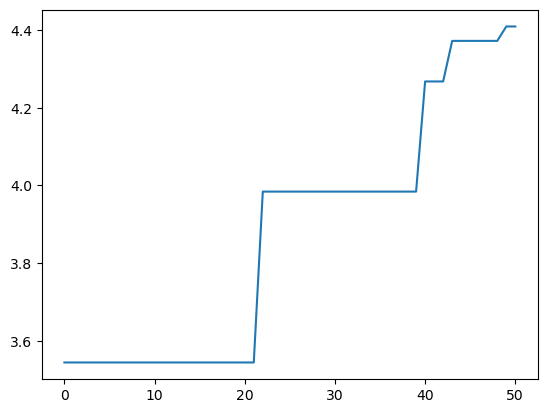

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 4.409001201423333
Flight 4 in Sleeve 1 - Flight 7 in Sleeve 5 - Flight 25 in Sleeve 6 - Flight 13 in Zone 0 - Flight 6 in Sleeve 4 - Flight 17 in Sleeve 8 - Flight 23 in Sleeve 3 - Flight 28 in Zone 9 - Flight 10 in Sleeve 7 - Flight 18 in Zone 2

Poblacion inicial, best_fitness = 4.067003190897056
generacion 0, (Mejor fitness = 4.067003190897056)
generacion 10, (Mejor fitness = 4.067003190897056)
generacion 20, (Mejor fitness = 4.131794041158146)
generacion 30, (Mejor fitness = 4.131794041158146)
generacion 40, (Mejor fitness = 4.200392702017668)


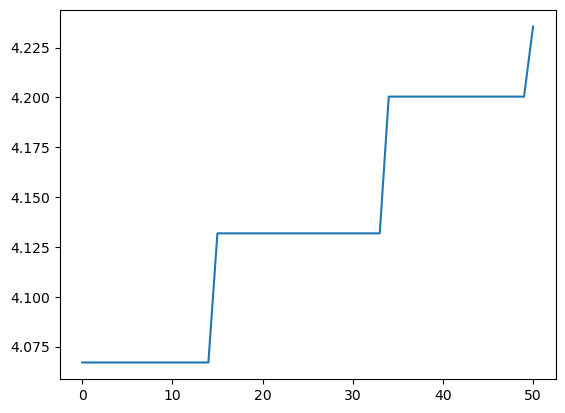

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 4.235598520087068
Flight 17 in Sleeve 1 - Flight 6 in Sleeve 6 - Flight 2 in Sleeve 5 - Flight 10 in Sleeve 7 - Flight 9 in Zone 0 - Flight 23 in Sleeve 3 - Flight 7 in Sleeve 8 - Flight 13 in Zone 9 - Flight 28 in Zone 2 - Flight 4 in Sleeve 4



Poblacion inicial, best_fitness = 3.6819014599134925
generacion 0, (Mejor fitness = 3.6819014599134925)
generacion 10, (Mejor fitness = 3.6819014599134925)
generacion 20, (Mejor fitness = 3.6819014599134925)
generacion 30, (Mejor fitness = 3.6819014599134925)
generacion 40, (Mejor fitness = 3.6819014599134925)


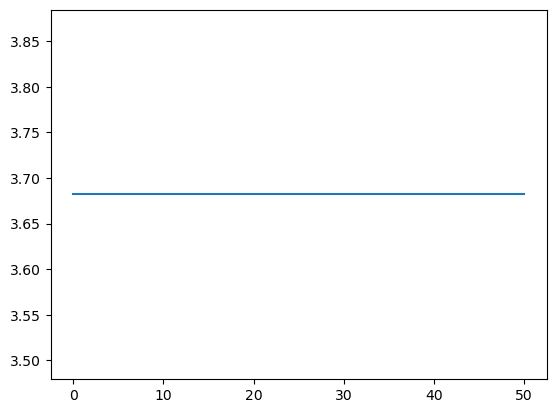

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.6819014599134925
Flight 22 in Sleeve 3 - Flight 6 in Sleeve 4 - Flight 27 in Zone 9 - Flight 9 in Zone 2 - Flight 1 in Sleeve 7 - Flight 16 in Sleeve 5 - Flight 21 in Sleeve 6 - Flight 18 in Sleeve 1 - Flight 28 in Zone 0 - Flight 12 in Sleeve 8

Poblacion inicial, best_fitness = 3.7487266944568853
generacion 0, (Mejor fitness = 3.7487266944568853)
generacion 10, (Mejor fitness = 3.7487266944568853)
generacion 20, (Mejor fitness = 3.810119482733308)
generacion 30, (Mejor fitness = 3.810119482733308)
generacion 40, (Mejor fitness = 3.810119482733308)


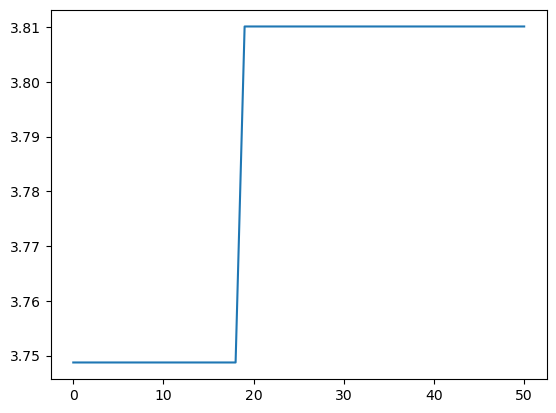

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.810119482733308
Flight 24 in Sleeve 8 - Flight 28 in Zone 2 - Flight 1 in Sleeve 3 - Flight 21 in Zone 9 - Flight 6 in Sleeve 4 - Flight 14 in Sleeve 6 - Flight 16 in Sleeve 7 - Flight 7 in Sleeve 1 - Flight 12 in Sleeve 5 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.3908501940729816
generacion 0, (Mejor fitness = 3.3908501940729816)
generacion 10, (Mejor fitness = 3.3908501940729816)
generacion 20, (Mejor fitness = 3.3908501940729816)
generacion 30, (Mejor fitness = 3.3908501940729816)
generacion 40, (Mejor fitness = 3.6100737411066657)


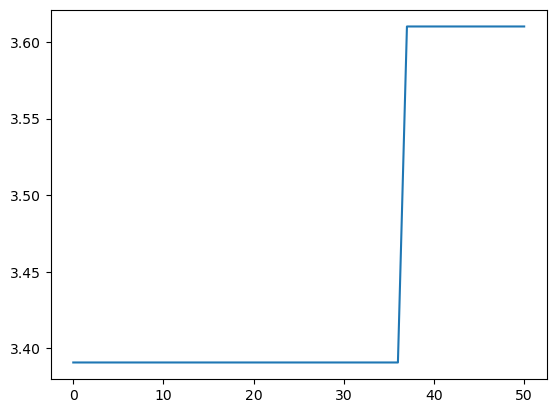

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.6100737411066657
Flight 13 in Sleeve 1 - Flight 11 in Sleeve 8 - Flight 28 in Zone 0 - Flight 1 in Zone 2 - Flight 17 in Sleeve 4 - Flight 5 in Sleeve 3 - Flight 29 in Sleeve 6 - Flight 8 in Sleeve 5 - Flight 3 in Zone 9 - Flight 25 in Sleeve 7

Poblacion inicial, best_fitness = 3.7207354062919813
generacion 0, (Mejor fitness = 3.7207354062919813)
generacion 10, (Mejor fitness = 3.9014826639223026)
generacion 20, (Mejor fitness = 3.9014826639223026)
generacion 30, (Mejor fitness = 3.9014826639223026)
generacion 40, (Mejor fitness = 3.9014826639223026)


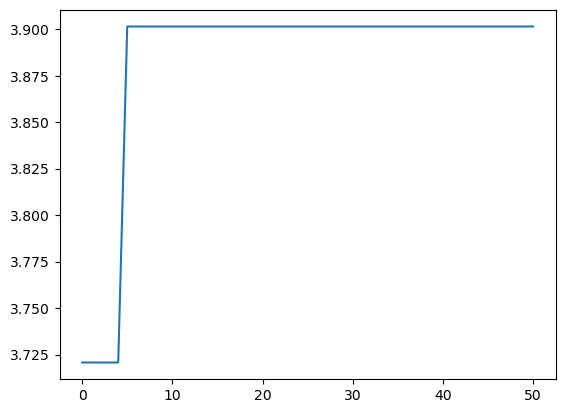

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.9014826639223026
Flight 5 in Zone 9 - Flight 12 in Sleeve 3 - Flight 18 in Sleeve 5 - Flight 28 in Zone 0 - Flight 3 in Zone 2 - Flight 25 in Sleeve 1 - Flight 22 in Sleeve 6 - Flight 27 in Sleeve 8 - Flight 17 in Sleeve 7 - Flight 13 in Sleeve 4

Poblacion inicial, best_fitness = 3.4118104498634656
generacion 0, (Mejor fitness = 3.4118104498634656)
generacion 10, (Mejor fitness = 3.4118104498634656)
generacion 20, (Mejor fitness = 3.4118104498634656)
generacion 30, (Mejor fitness = 3.532844072462982)
generacion 40, (Mejor fitness = 3.9434351622211548)


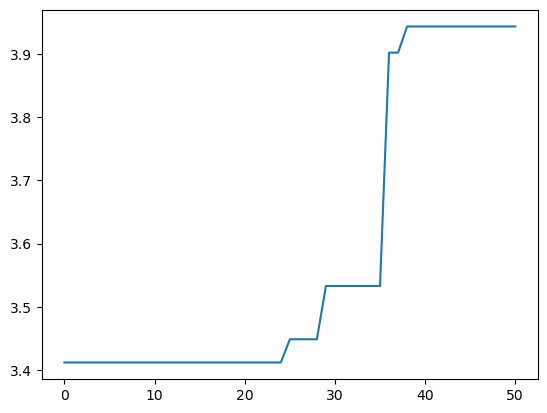

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.9434351622211548
Flight 19 in Zone 2 - Flight 21 in Sleeve 6 - Flight 28 in Zone 9 - Flight 2 in Sleeve 8 - Flight 12 in Sleeve 3 - Flight 11 in Sleeve 5 - Flight 13 in Zone 0 - Flight 17 in Sleeve 1 - Flight 9 in Sleeve 7 - Flight 6 in Sleeve 4

Poblacion inicial, best_fitness = 3.8636697321282614
generacion 0, (Mejor fitness = 3.8636697321282614)
generacion 10, (Mejor fitness = 3.8636697321282614)
generacion 20, (Mejor fitness = 3.8636697321282614)
generacion 30, (Mejor fitness = 3.8636697321282614)
generacion 40, (Mejor fitness = 3.8636697321282614)


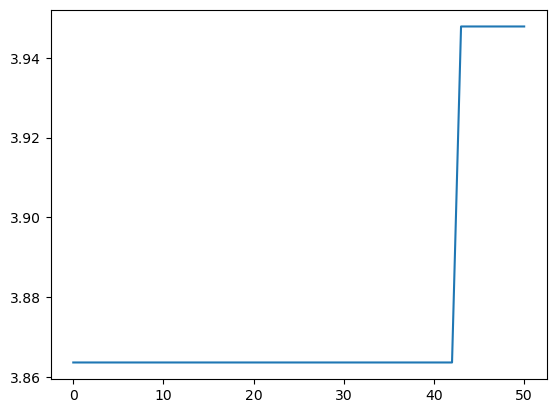

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.9478188634677425
Flight 3 in Sleeve 4 - Flight 19 in Zone 0 - Flight 11 in Sleeve 7 - Flight 12 in Sleeve 1 - Flight 4 in Sleeve 5 - Flight 1 in Zone 2 - Flight 22 in Sleeve 8 - Flight 7 in Sleeve 3 - Flight 25 in Sleeve 6 - Flight 28 in Zone 9

Poblacion inicial, best_fitness = 3.6104611227278345
generacion 0, (Mejor fitness = 3.6104611227278345)
generacion 10, (Mejor fitness = 3.6104611227278345)
generacion 20, (Mejor fitness = 3.6104611227278345)
generacion 30, (Mejor fitness = 3.6104611227278345)
generacion 40, (Mejor fitness = 3.971785966157646)


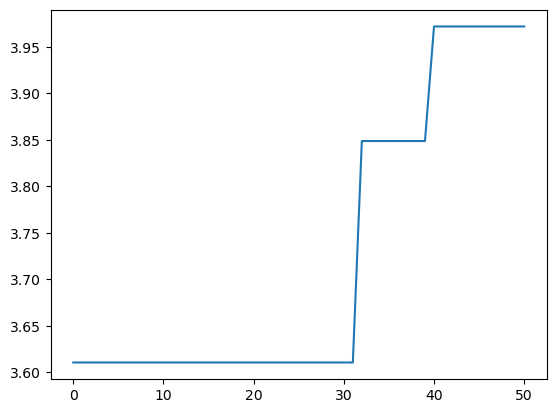

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.971785966157646
Flight 11 in Sleeve 7 - Flight 28 in Zone 2 - Flight 6 in Sleeve 5 - Flight 17 in Zone 9 - Flight 20 in Zone 0 - Flight 23 in Sleeve 3 - Flight 18 in Sleeve 1 - Flight 3 in Sleeve 8 - Flight 13 in Sleeve 6 - Flight 9 in Sleeve 4

Poblacion inicial, best_fitness = 3.5318094294151128
generacion 0, (Mejor fitness = 3.5318094294151128)
generacion 10, (Mejor fitness = 3.5318094294151128)
generacion 20, (Mejor fitness = 3.5318094294151128)
generacion 30, (Mejor fitness = 4.027436790156256)
generacion 40, (Mejor fitness = 4.027436790156256)


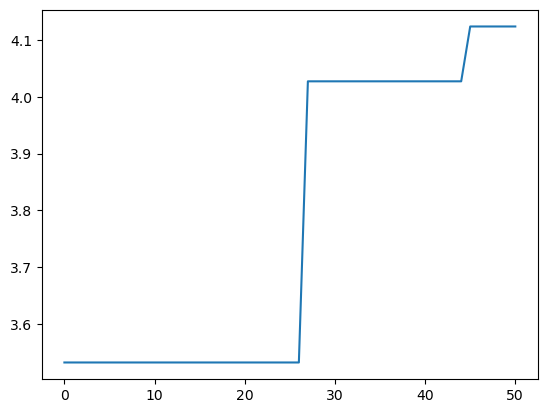

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 4.124120029141106
Flight 6 in Sleeve 6 - Flight 3 in Zone 9 - Flight 11 in Sleeve 7 - Flight 27 in Sleeve 8 - Flight 18 in Sleeve 5 - Flight 21 in Sleeve 4 - Flight 29 in Sleeve 3 - Flight 7 in Zone 0 - Flight 28 in Zone 2 - Flight 16 in Sleeve 1



In [24]:
experimentacion("Codigo con crossover uniform y mutation position")

In [25]:
df_resultado_base = pd.DataFrame(rows)

In [26]:
df_resultado_base

,Tag,Fitness,Selection,Crossover,Mutation,Pmut,Asignacion
0,Codigo con crossover uniform y mutation position,4.409001,roulette,uniform,position,0.7,Flight 4 in Sleeve 1 - Flight 7 in Sleeve 5 - ...
1,Codigo con crossover uniform y mutation position,4.235599,roulette,uniform,position,0.7,Flight 17 in Sleeve 1 - Flight 6 in Sleeve 6 -...
2,Codigo con crossover uniform y mutation position,3.681901,roulette,uniform,position,0.7,Flight 22 in Sleeve 3 - Flight 6 in Sleeve 4 -...
3,Codigo con crossover uniform y mutation position,3.810119,roulette,uniform,position,0.7,Flight 24 in Sleeve 8 - Flight 28 in Zone 2 - ...
4,Codigo con crossover uniform y mutation position,3.610074,roulette,uniform,position,0.7,Flight 13 in Sleeve 1 - Flight 11 in Sleeve 8 ...
5,Codigo con crossover uniform y mutation position,3.901483,roulette,uniform,position,0.7,Flight 5 in Zone 9 - Flight 12 in Sleeve 3 - F...
6,Codigo con crossover uniform y mutation position,3.943435,roulette,uniform,position,0.7,Flight 19 in Zone 2 - Flight 21 in Sleeve 6 - ...
7,Codigo con crossover uniform y mutation position,3.947819,roulette,uniform,position,0.7,Flight 3 in Sleeve 4 - Flight 19 in Zone 0 - F...
8,Codigo con crossover uniform y mutation position,3.971786,roulette,uniform,position,0.7,Flight 11 in Sleeve 7 - Flight 28 in Zone 2 - ...
9,Codigo con crossover uniform y mutation position,4.124120,roulette,uniform,position,0.7,Flight 6 in Sleeve 6 - Flight 3 in Zone 9 - Fl...


### Codigo con crossover order_permutation y mutation swap

Poblacion inicial, best_fitness = 3.5223682252471185
generacion 0, (Mejor fitness = 3.5927473007688278)
generacion 10, (Mejor fitness = 4.538080625812715)
generacion 20, (Mejor fitness = 4.772961890654404)
generacion 30, (Mejor fitness = 4.9148456308483155)
generacion 40, (Mejor fitness = 4.936662043594186)


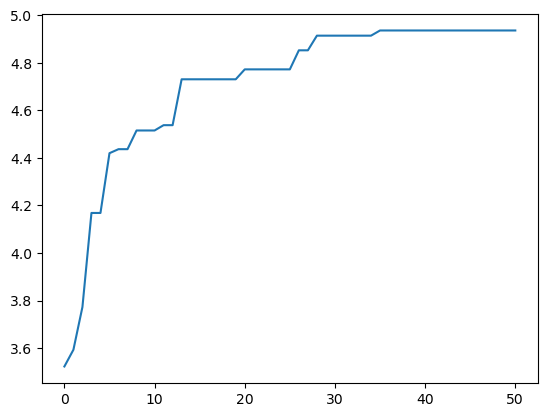

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.936662043594186
Flight 21 in Sleeve 8 - Flight 7 in Sleeve 1 - Flight 9 in Sleeve 5 - Flight 18 in Sleeve 6 - Flight 16 in Sleeve 7 - Flight 4 in Sleeve 4 - Flight 13 in Zone 0 - Flight 28 in Zone 9 - Flight 19 in Sleeve 3 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.5309910320758227
generacion 0, (Mejor fitness = 3.6527935125808653)
generacion 10, (Mejor fitness = 4.4818921340161255)
generacion 20, (Mejor fitness = 4.586752829612874)
generacion 30, (Mejor fitness = 4.739119451524702)
generacion 40, (Mejor fitness = 4.799952675253417)


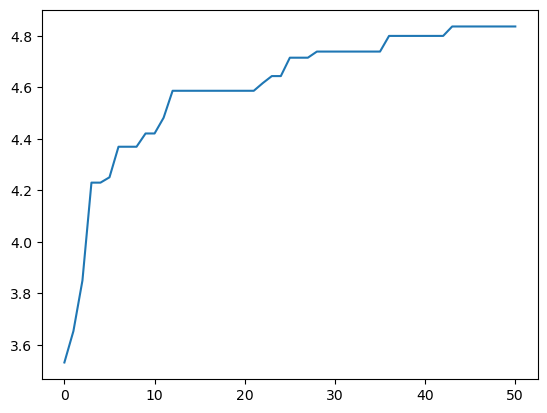

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.8366174633785235
Flight 19 in Sleeve 8 - Flight 12 in Sleeve 7 - Flight 28 in Zone 9 - Flight 7 in Sleeve 1 - Flight 24 in Sleeve 5 - Flight 18 in Sleeve 3 - Flight 3 in Zone 0 - Flight 4 in Sleeve 4 - Flight 25 in Sleeve 6 - Flight 13 in Zone 2

Poblacion inicial, best_fitness = 3.4484467749520986
generacion 0, (Mejor fitness = 3.73393801107543)
generacion 10, (Mejor fitness = 4.795577681120348)
generacion 20, (Mejor fitness = 4.8530348962517795)
generacion 30, (Mejor fitness = 4.985511872139194)
generacion 40, (Mejor fitness = 5.014113766096418)


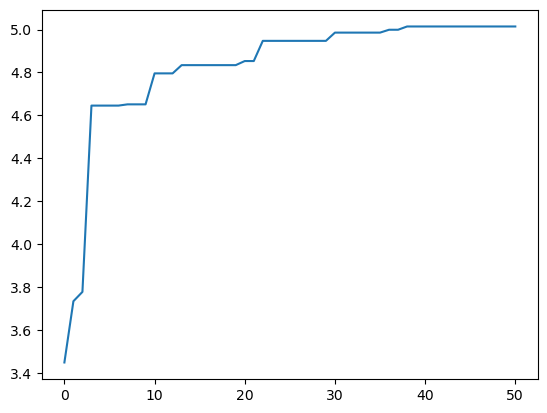

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.014113766096418
Flight 4 in Sleeve 4 - Flight 25 in Sleeve 3 - Flight 19 in Sleeve 7 - Flight 17 in Sleeve 8 - Flight 28 in Zone 9 - Flight 3 in Zone 2 - Flight 7 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 18 in Sleeve 5 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.9070091639453546
generacion 0, (Mejor fitness = 3.9070091639453546)
generacion 10, (Mejor fitness = 4.863154034360671)
generacion 20, (Mejor fitness = 4.974749345251855)
generacion 30, (Mejor fitness = 4.974749345251855)
generacion 40, (Mejor fitness = 4.974749345251855)


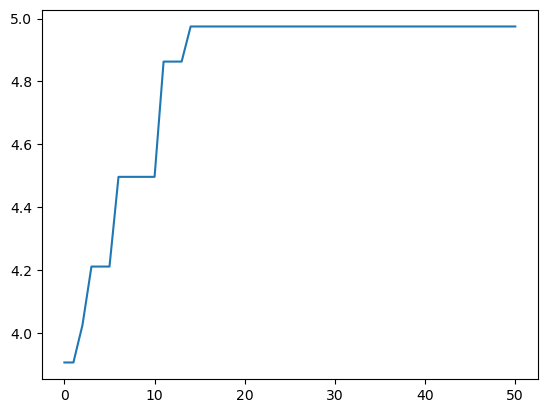

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.974749345251855
Flight 9 in Sleeve 6 - Flight 16 in Sleeve 7 - Flight 7 in Sleeve 1 - Flight 2 in Sleeve 3 - Flight 13 in Zone 0 - Flight 4 in Sleeve 4 - Flight 25 in Sleeve 8 - Flight 3 in Zone 9 - Flight 6 in Sleeve 5 - Flight 28 in Zone 2

Poblacion inicial, best_fitness = 4.3377221574281775
generacion 0, (Mejor fitness = 4.3377221574281775)
generacion 10, (Mejor fitness = 4.713631892607572)
generacion 20, (Mejor fitness = 4.713631892607572)
generacion 30, (Mejor fitness = 4.80744633298586)
generacion 40, (Mejor fitness = 4.88880252196959)


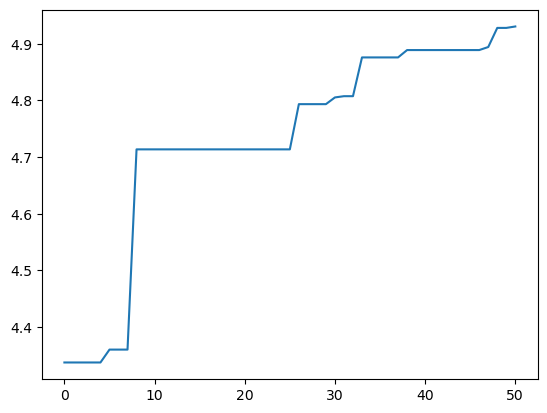

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.9304043577878796
Flight 19 in Sleeve 5 - Flight 16 in Sleeve 3 - Flight 25 in Sleeve 6 - Flight 10 in Sleeve 8 - Flight 13 in Zone 0 - Flight 6 in Sleeve 7 - Flight 4 in Sleeve 4 - Flight 7 in Sleeve 1 - Flight 28 in Zone 9 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.2521666522118053
generacion 0, (Mejor fitness = 3.3872244822719746)
generacion 10, (Mejor fitness = 4.651989360245883)
generacion 20, (Mejor fitness = 4.844268063430471)
generacion 30, (Mejor fitness = 4.8556099176739504)
generacion 40, (Mejor fitness = 4.89431717138992)


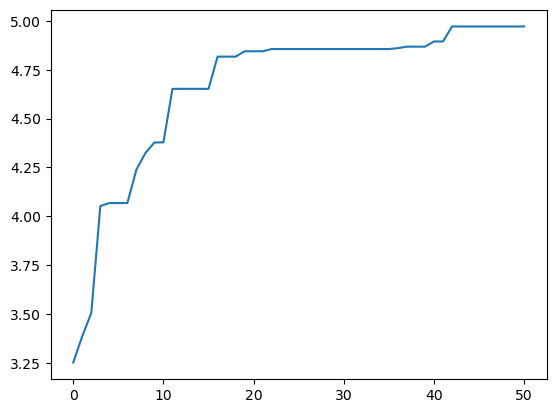

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.97106544819228
Flight 13 in Zone 0 - Flight 9 in Sleeve 1 - Flight 7 in Sleeve 8 - Flight 4 in Sleeve 4 - Flight 19 in Sleeve 6 - Flight 3 in Zone 2 - Flight 28 in Zone 9 - Flight 25 in Sleeve 3 - Flight 18 in Sleeve 5 - Flight 16 in Sleeve 7

Poblacion inicial, best_fitness = 3.8640611532859896
generacion 0, (Mejor fitness = 3.8640611532859896)
generacion 10, (Mejor fitness = 4.6185979328089815)
generacion 20, (Mejor fitness = 4.743580487931366)
generacion 30, (Mejor fitness = 4.9562709086850285)
generacion 40, (Mejor fitness = 4.985467447693524)


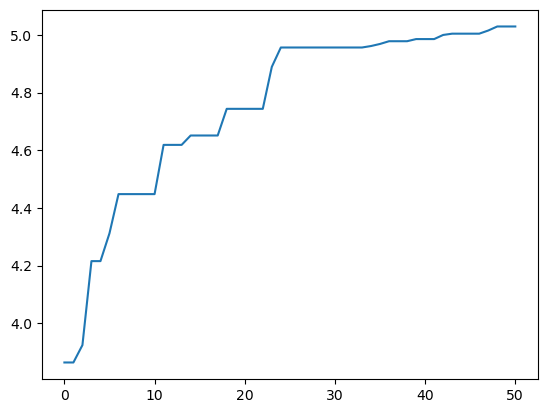

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.029165914057212
Flight 7 in Sleeve 5 - Flight 28 in Zone 9 - Flight 3 in Zone 2 - Flight 18 in Sleeve 6 - Flight 13 in Zone 0 - Flight 17 in Sleeve 7 - Flight 12 in Sleeve 3 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 16 in Sleeve 8

Poblacion inicial, best_fitness = 3.5893203908905935
generacion 0, (Mejor fitness = 3.5893203908905935)
generacion 10, (Mejor fitness = 4.406083490633018)
generacion 20, (Mejor fitness = 4.806677009109167)
generacion 30, (Mejor fitness = 4.838276161032113)
generacion 40, (Mejor fitness = 4.943380815053706)


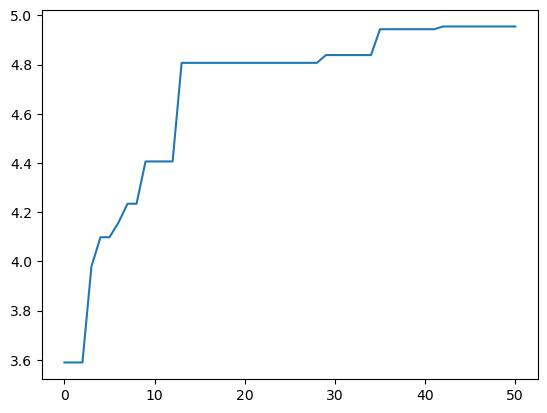

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.95448892534783
Flight 19 in Sleeve 1 - Flight 17 in Sleeve 8 - Flight 25 in Sleeve 7 - Flight 18 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 13 in Zone 0 - Flight 7 in Sleeve 5 - Flight 28 in Zone 2 - Flight 16 in Sleeve 3 - Flight 3 in Zone 9

Poblacion inicial, best_fitness = 3.5853007737298483
generacion 0, (Mejor fitness = 3.803948289442272)
generacion 10, (Mejor fitness = 4.684653201779846)
generacion 20, (Mejor fitness = 4.803006103227277)
generacion 30, (Mejor fitness = 4.887961370942035)
generacion 40, (Mejor fitness = 4.944027050987156)


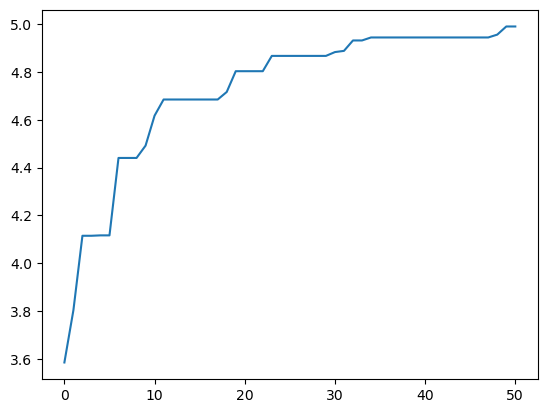

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.989956335270693
Flight 3 in Zone 2 - Flight 28 in Zone 9 - Flight 25 in Sleeve 6 - Flight 13 in Zone 0 - Flight 6 in Sleeve 8 - Flight 9 in Sleeve 4 - Flight 16 in Sleeve 3 - Flight 4 in Sleeve 5 - Flight 7 in Sleeve 1 - Flight 18 in Sleeve 7

Poblacion inicial, best_fitness = 3.5864663264713528
generacion 0, (Mejor fitness = 3.590787425008846)
generacion 10, (Mejor fitness = 4.459168326545841)
generacion 20, (Mejor fitness = 4.712337626799892)
generacion 30, (Mejor fitness = 4.899177791233536)
generacion 40, (Mejor fitness = 4.930652348546072)


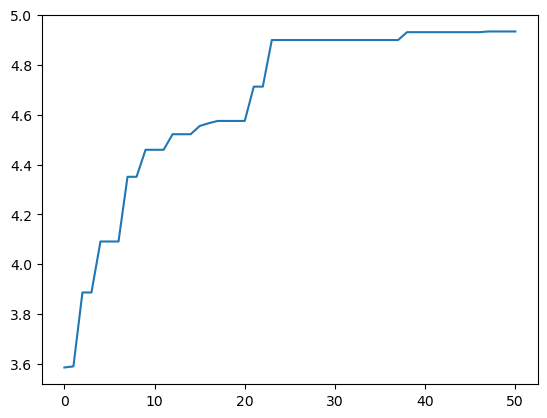

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.9334516060777105
Flight 28 in Zone 9 - Flight 24 in Sleeve 8 - Flight 16 in Sleeve 6 - Flight 13 in Zone 2 - Flight 3 in Zone 0 - Flight 17 in Sleeve 3 - Flight 7 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 18 in Sleeve 5 - Flight 25 in Sleeve 7



In [27]:
experimentacion("Codigo con crossover order_permutation y mutation swap", "roulette", "crossover_orderpermutation", "swap")

### Codigo con crossover order_permutation y sin mutacion

Poblacion inicial, best_fitness = 4.176033574196053
generacion 0, (Mejor fitness = 4.176033574196053)
generacion 10, (Mejor fitness = 4.686792175659258)
generacion 20, (Mejor fitness = 4.8650824096325564)
generacion 30, (Mejor fitness = 4.9594633933787895)
generacion 40, (Mejor fitness = 4.978912149886536)


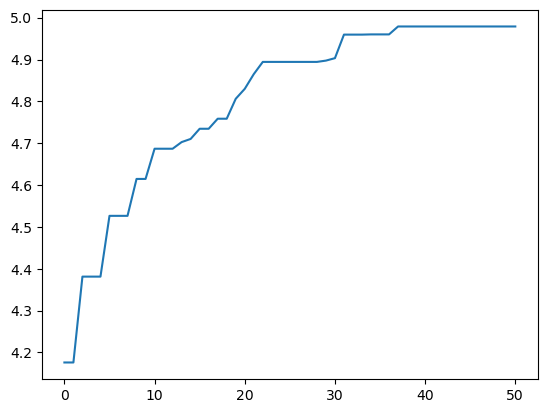

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.978912149886536
Flight 28 in Zone 9 - Flight 20 in Sleeve 8 - Flight 16 in Sleeve 7 - Flight 7 in Sleeve 5 - Flight 3 in Zone 0 - Flight 6 in Sleeve 3 - Flight 13 in Zone 2 - Flight 18 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 1

Poblacion inicial, best_fitness = 3.4807098748900303
generacion 0, (Mejor fitness = 3.7128379118587627)
generacion 10, (Mejor fitness = 4.607749446011789)
generacion 20, (Mejor fitness = 4.607749446011789)
generacion 30, (Mejor fitness = 4.768687265409864)
generacion 40, (Mejor fitness = 4.818442711142949)


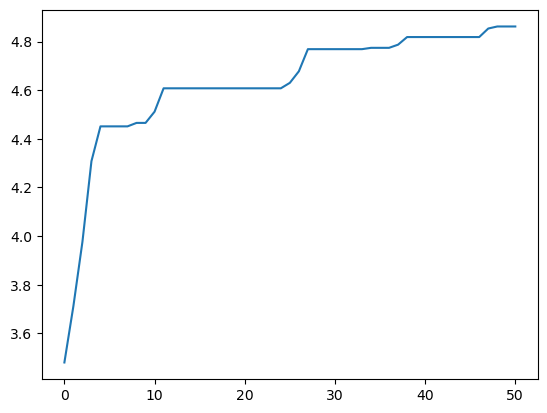

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.861921525211214
Flight 12 in Sleeve 5 - Flight 9 in Sleeve 4 - Flight 10 in Sleeve 8 - Flight 3 in Zone 0 - Flight 16 in Sleeve 7 - Flight 18 in Sleeve 6 - Flight 28 in Zone 9 - Flight 7 in Sleeve 1 - Flight 13 in Zone 2 - Flight 19 in Sleeve 3

Poblacion inicial, best_fitness = 3.8158745652391577
generacion 0, (Mejor fitness = 3.8158745652391577)
generacion 10, (Mejor fitness = 4.763708098287405)
generacion 20, (Mejor fitness = 4.861316684321142)
generacion 30, (Mejor fitness = 4.992313650008413)
generacion 40, (Mejor fitness = 5.017176460204589)


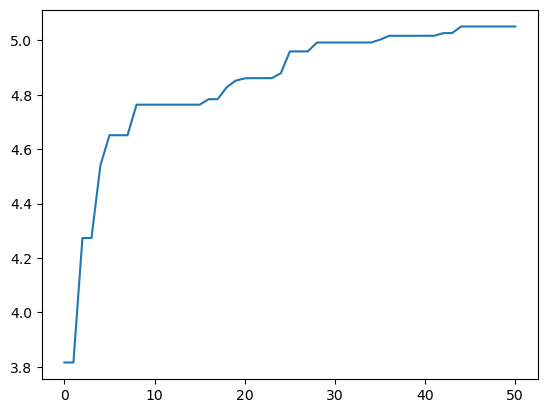

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.0512668117559665
Flight 3 in Zone 0 - Flight 7 in Sleeve 1 - Flight 18 in Sleeve 7 - Flight 9 in Sleeve 6 - Flight 28 in Zone 9 - Flight 4 in Sleeve 4 - Flight 13 in Zone 2 - Flight 25 in Sleeve 5 - Flight 12 in Sleeve 3 - Flight 16 in Sleeve 8

Poblacion inicial, best_fitness = 4.035032046726542
generacion 0, (Mejor fitness = 4.035032046726542)
generacion 10, (Mejor fitness = 4.832843028828503)
generacion 20, (Mejor fitness = 5.016423045454989)
generacion 30, (Mejor fitness = 5.035686113464818)
generacion 40, (Mejor fitness = 5.035686113464818)


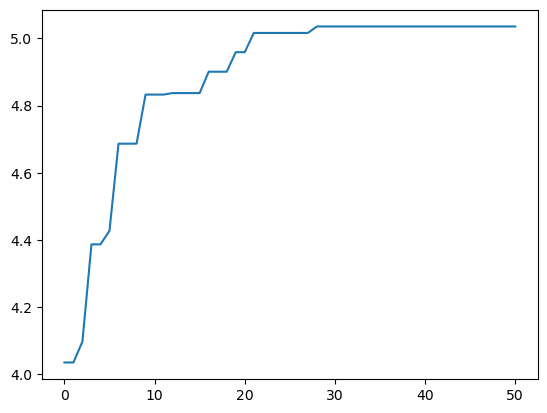

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.035686113464818
Flight 13 in Zone 0 - Flight 3 in Zone 2 - Flight 24 in Sleeve 3 - Flight 28 in Zone 9 - Flight 18 in Sleeve 5 - Flight 7 in Sleeve 1 - Flight 16 in Sleeve 8 - Flight 9 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 25 in Sleeve 7

Poblacion inicial, best_fitness = 3.5868739193301122
generacion 0, (Mejor fitness = 3.5868739193301122)
generacion 10, (Mejor fitness = 4.321944930096253)
generacion 20, (Mejor fitness = 4.541143226527288)
generacion 30, (Mejor fitness = 4.656842556200186)
generacion 40, (Mejor fitness = 4.656842556200186)


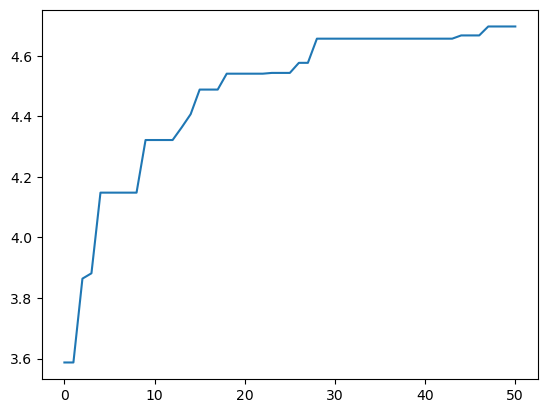

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.697129360825674
Flight 19 in Sleeve 6 - Flight 9 in Sleeve 7 - Flight 28 in Zone 9 - Flight 17 in Sleeve 3 - Flight 25 in Sleeve 8 - Flight 20 in Zone 2 - Flight 6 in Sleeve 5 - Flight 7 in Sleeve 4 - Flight 4 in Sleeve 1 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.3161694667659636
generacion 0, (Mejor fitness = 3.662381170551057)
generacion 10, (Mejor fitness = 4.4701784376190385)
generacion 20, (Mejor fitness = 4.862651297458598)
generacion 30, (Mejor fitness = 4.9595750257316205)
generacion 40, (Mejor fitness = 5.044581553979141)


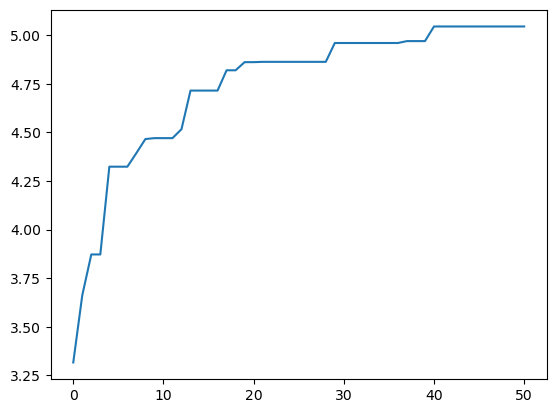

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.044581553979141
Flight 7 in Sleeve 5 - Flight 28 in Zone 9 - Flight 4 in Sleeve 1 - Flight 9 in Sleeve 4 - Flight 16 in Sleeve 8 - Flight 6 in Sleeve 3 - Flight 25 in Sleeve 7 - Flight 3 in Zone 2 - Flight 18 in Sleeve 6 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.721830805586435
generacion 0, (Mejor fitness = 3.873563934844852)
generacion 10, (Mejor fitness = 4.563726398327791)
generacion 20, (Mejor fitness = 4.671453590556024)
generacion 30, (Mejor fitness = 4.900255975190441)
generacion 40, (Mejor fitness = 4.910440868604133)


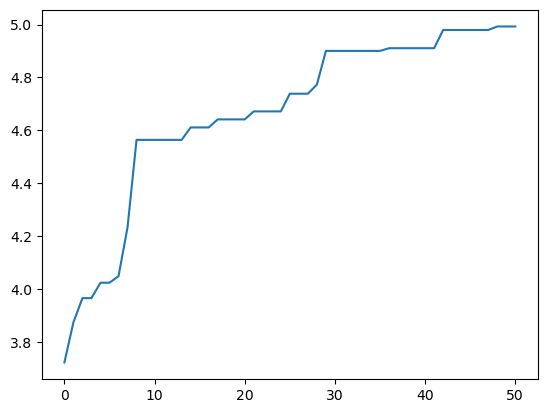

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.9926251023920845
Flight 18 in Sleeve 6 - Flight 7 in Sleeve 4 - Flight 4 in Sleeve 1 - Flight 13 in Zone 2 - Flight 25 in Sleeve 8 - Flight 28 in Zone 9 - Flight 17 in Sleeve 3 - Flight 9 in Sleeve 7 - Flight 16 in Sleeve 5 - Flight 3 in Zone 0

Poblacion inicial, best_fitness = 3.433704379980161
generacion 0, (Mejor fitness = 3.509747541613498)
generacion 10, (Mejor fitness = 4.755009246425402)
generacion 20, (Mejor fitness = 4.89314565519259)
generacion 30, (Mejor fitness = 4.990504979327814)
generacion 40, (Mejor fitness = 5.015259805909844)


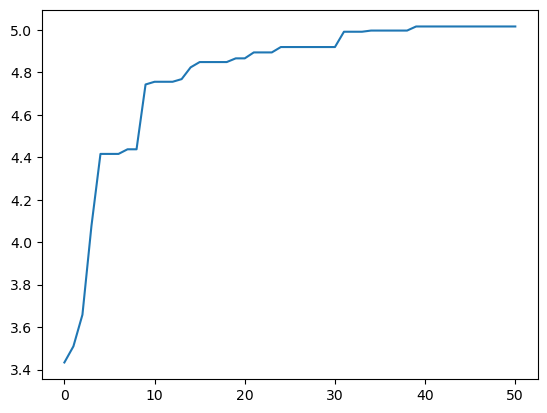

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.015259805909844
Flight 4 in Sleeve 4 - Flight 18 in Sleeve 7 - Flight 7 in Sleeve 6 - Flight 28 in Zone 9 - Flight 3 in Zone 2 - Flight 9 in Sleeve 1 - Flight 13 in Zone 0 - Flight 16 in Sleeve 5 - Flight 10 in Sleeve 3 - Flight 19 in Sleeve 8

Poblacion inicial, best_fitness = 3.7320525619930334
generacion 0, (Mejor fitness = 3.7320525619930334)
generacion 10, (Mejor fitness = 4.507765243457135)
generacion 20, (Mejor fitness = 4.786466901281509)
generacion 30, (Mejor fitness = 4.837923209673234)
generacion 40, (Mejor fitness = 4.837923209673234)


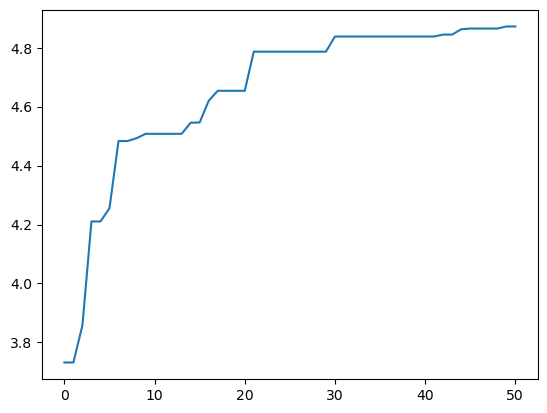

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.871967959095487
Flight 6 in Sleeve 6 - Flight 25 in Sleeve 7 - Flight 19 in Zone 9 - Flight 16 in Sleeve 5 - Flight 28 in Zone 2 - Flight 18 in Sleeve 8 - Flight 4 in Sleeve 4 - Flight 3 in Zone 0 - Flight 12 in Sleeve 3 - Flight 7 in Sleeve 1

Poblacion inicial, best_fitness = 3.7544725512809025
generacion 0, (Mejor fitness = 3.7544725512809025)
generacion 10, (Mejor fitness = 4.61646839256337)
generacion 20, (Mejor fitness = 4.7631040517922365)
generacion 30, (Mejor fitness = 4.876575285824913)
generacion 40, (Mejor fitness = 4.905867904907562)


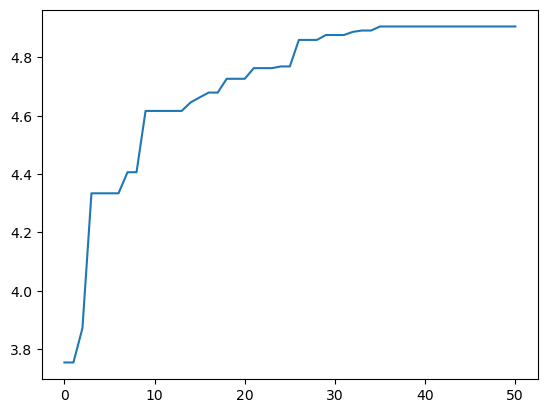

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.905867904907562
Flight 11 in Sleeve 3 - Flight 20 in Zone 0 - Flight 3 in Zone 9 - Flight 18 in Sleeve 5 - Flight 16 in Sleeve 8 - Flight 7 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 28 in Zone 2 - Flight 6 in Sleeve 7



In [28]:
experimentacion("Codigo con crossover order_permutation y sin mutacion", "roulette", "crossover_orderpermutation", "swap", p_mut=0)

### Codigo con crossover order_permutation y mutation swap tasa 0.1

Poblacion inicial, best_fitness = 3.753638680550176
generacion 0, (Mejor fitness = 3.753638680550176)
generacion 10, (Mejor fitness = 4.556780022557872)
generacion 20, (Mejor fitness = 4.767085793901546)
generacion 30, (Mejor fitness = 4.860558915996558)
generacion 40, (Mejor fitness = 4.895164181325963)


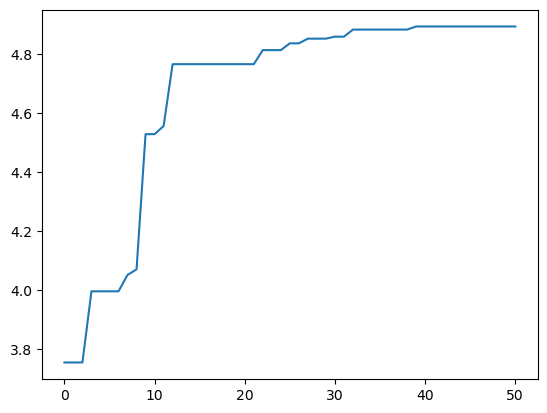

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.895164181325963
Flight 3 in Zone 9 - Flight 25 in Sleeve 7 - Flight 10 in Sleeve 8 - Flight 9 in Sleeve 4 - Flight 13 in Zone 0 - Flight 7 in Sleeve 1 - Flight 20 in Sleeve 6 - Flight 18 in Sleeve 5 - Flight 28 in Zone 2 - Flight 12 in Sleeve 3

Poblacion inicial, best_fitness = 3.735464985776235
generacion 0, (Mejor fitness = 3.875511661011652)
generacion 10, (Mejor fitness = 4.639562774884763)
generacion 20, (Mejor fitness = 4.7880428693144195)
generacion 30, (Mejor fitness = 4.922394268886593)
generacion 40, (Mejor fitness = 5.054549905338023)


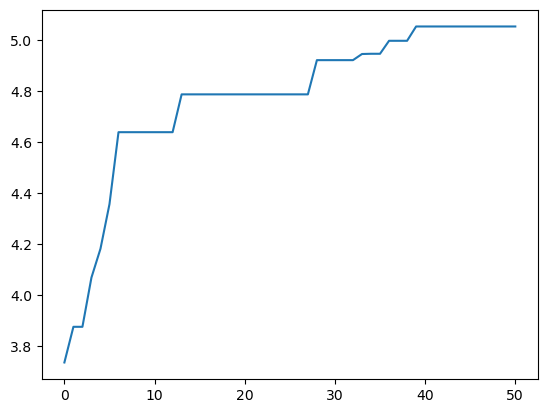

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.054549905338023
Flight 2 in Sleeve 3 - Flight 28 in Zone 9 - Flight 13 in Zone 0 - Flight 3 in Zone 2 - Flight 7 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 5 - Flight 16 in Sleeve 8 - Flight 25 in Sleeve 7

Poblacion inicial, best_fitness = 3.663463553753598
generacion 0, (Mejor fitness = 3.6830965347666833)
generacion 10, (Mejor fitness = 4.668343538077526)
generacion 20, (Mejor fitness = 4.8546014220520135)
generacion 30, (Mejor fitness = 4.880896782772862)
generacion 40, (Mejor fitness = 4.8918639354121)


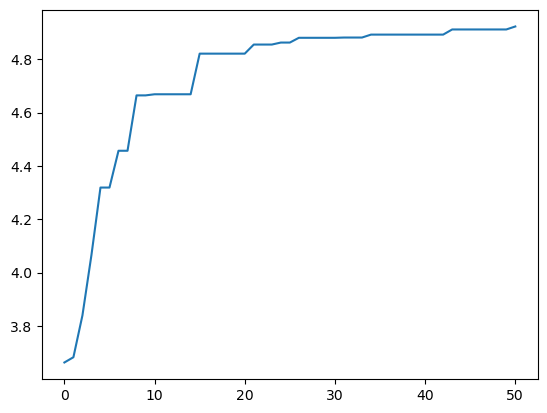

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.922324589430911
Flight 12 in Sleeve 3 - Flight 28 in Zone 2 - Flight 3 in Zone 9 - Flight 19 in Sleeve 7 - Flight 20 in Zone 0 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 6 - Flight 18 in Sleeve 5 - Flight 7 in Sleeve 1 - Flight 25 in Sleeve 8

Poblacion inicial, best_fitness = 3.4911283176017474
generacion 0, (Mejor fitness = 3.6263949610768016)
generacion 10, (Mejor fitness = 4.574809122432814)
generacion 20, (Mejor fitness = 4.969194974412656)
generacion 30, (Mejor fitness = 5.020769369752861)
generacion 40, (Mejor fitness = 5.040333257522516)


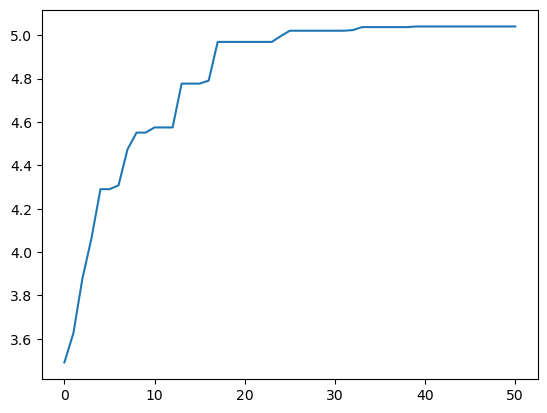

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.040333257522516
Flight 25 in Sleeve 5 - Flight 16 in Sleeve 8 - Flight 10 in Sleeve 3 - Flight 18 in Sleeve 6 - Flight 7 in Sleeve 1 - Flight 4 in Sleeve 4 - Flight 3 in Zone 2 - Flight 28 in Zone 9 - Flight 6 in Sleeve 7 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.5353522374890693
generacion 0, (Mejor fitness = 3.5353522374890693)
generacion 10, (Mejor fitness = 4.418024972495241)
generacion 20, (Mejor fitness = 4.8152233456572855)
generacion 30, (Mejor fitness = 4.8516039934581965)
generacion 40, (Mejor fitness = 4.928963971504438)


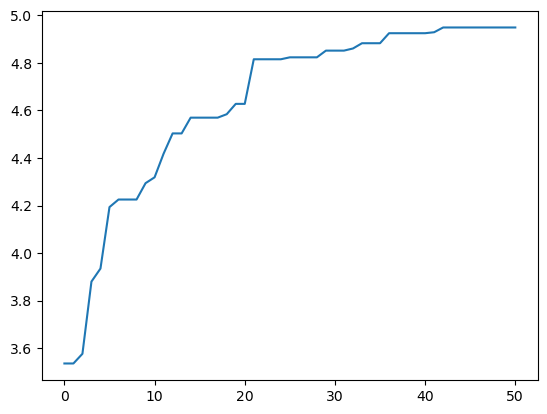

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.948985647849946
Flight 13 in Zone 0 - Flight 19 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 24 in Sleeve 8 - Flight 12 in Sleeve 3 - Flight 28 in Zone 9 - Flight 3 in Zone 2 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 7 - Flight 7 in Sleeve 5

Poblacion inicial, best_fitness = 4.147287484384324
generacion 0, (Mejor fitness = 4.147287484384324)
generacion 10, (Mejor fitness = 4.813318470968709)
generacion 20, (Mejor fitness = 4.854486047095855)
generacion 30, (Mejor fitness = 4.94507412528451)
generacion 40, (Mejor fitness = 4.996748530226792)


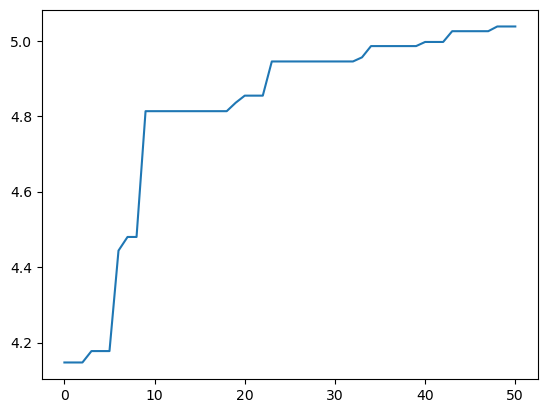

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.037789041406177
Flight 3 in Zone 9 - Flight 6 in Sleeve 3 - Flight 18 in Sleeve 5 - Flight 13 in Zone 0 - Flight 4 in Sleeve 1 - Flight 28 in Zone 2 - Flight 16 in Sleeve 7 - Flight 9 in Sleeve 4 - Flight 7 in Sleeve 6 - Flight 25 in Sleeve 8

Poblacion inicial, best_fitness = 3.9729064582937994
generacion 0, (Mejor fitness = 3.9729064582937994)
generacion 10, (Mejor fitness = 4.373878408825487)
generacion 20, (Mejor fitness = 4.733528902802031)
generacion 30, (Mejor fitness = 4.882700954672892)
generacion 40, (Mejor fitness = 4.953180239413786)


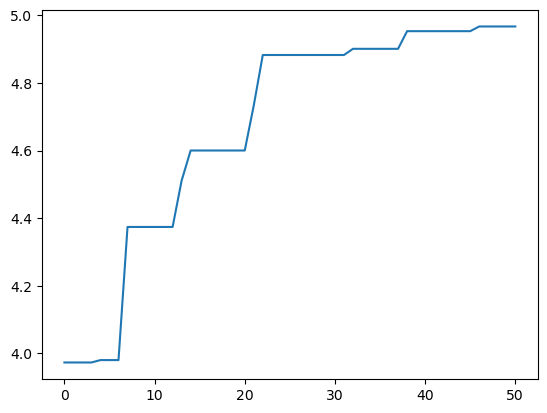

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.967075347580917
Flight 7 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 17 in Sleeve 7 - Flight 18 in Sleeve 5 - Flight 19 in Sleeve 8 - Flight 27 in Sleeve 3 - Flight 13 in Zone 0 - Flight 28 in Zone 9 - Flight 3 in Zone 2 - Flight 9 in Sleeve 1

Poblacion inicial, best_fitness = 3.722579486579666
generacion 0, (Mejor fitness = 3.722579486579666)
generacion 10, (Mejor fitness = 4.718441348624403)
generacion 20, (Mejor fitness = 4.919973098489489)
generacion 30, (Mejor fitness = 5.018087447674426)
generacion 40, (Mejor fitness = 5.024142627066045)


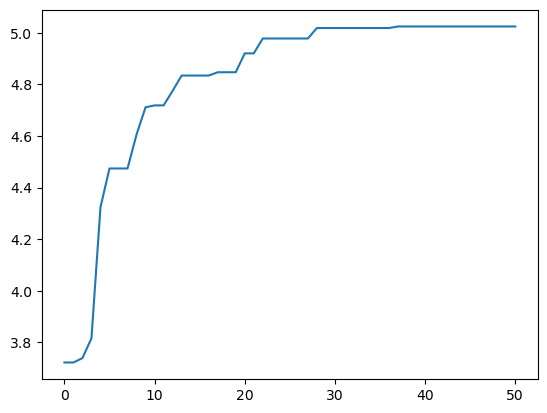

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.024142627066045
Flight 28 in Zone 9 - Flight 16 in Sleeve 7 - Flight 19 in Sleeve 3 - Flight 9 in Sleeve 1 - Flight 18 in Sleeve 6 - Flight 6 in Sleeve 8 - Flight 3 in Zone 2 - Flight 13 in Zone 0 - Flight 4 in Sleeve 4 - Flight 7 in Sleeve 5

Poblacion inicial, best_fitness = 3.3760666733257816
generacion 0, (Mejor fitness = 3.7257880045737704)
generacion 10, (Mejor fitness = 4.5678014046215125)
generacion 20, (Mejor fitness = 4.782080108711923)
generacion 30, (Mejor fitness = 4.869413112448957)
generacion 40, (Mejor fitness = 4.9279970833938895)


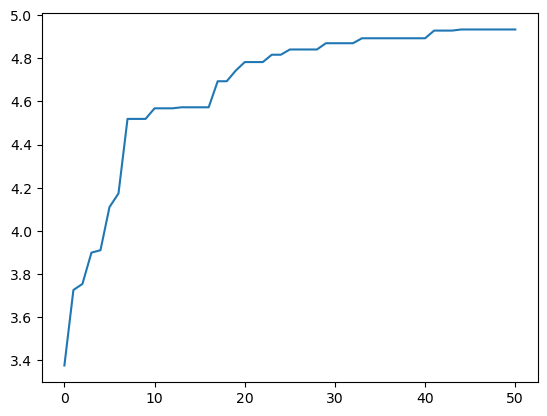

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.933138169007662
Flight 4 in Sleeve 1 - Flight 20 in Sleeve 3 - Flight 19 in Sleeve 8 - Flight 28 in Zone 2 - Flight 7 in Sleeve 4 - Flight 3 in Zone 9 - Flight 6 in Sleeve 6 - Flight 13 in Zone 0 - Flight 25 in Sleeve 7 - Flight 18 in Sleeve 5

Poblacion inicial, best_fitness = 3.497993342374986
generacion 0, (Mejor fitness = 3.9919610464274333)
generacion 10, (Mejor fitness = 4.523870782922797)
generacion 20, (Mejor fitness = 4.689322494890679)
generacion 30, (Mejor fitness = 4.8449514137364265)
generacion 40, (Mejor fitness = 4.908395708660171)


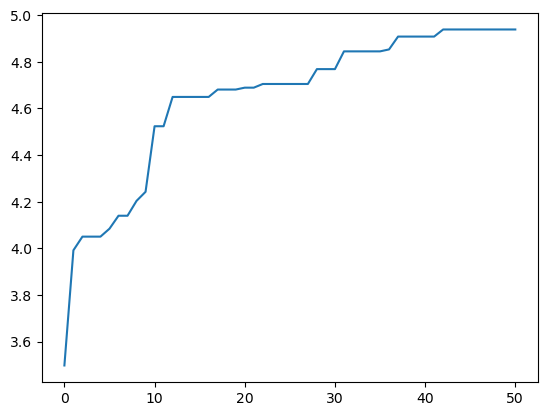

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.938830723042924
Flight 10 in Sleeve 8 - Flight 16 in Sleeve 7 - Flight 18 in Sleeve 5 - Flight 13 in Zone 0 - Flight 19 in Sleeve 3 - Flight 7 in Sleeve 1 - Flight 25 in Sleeve 6 - Flight 3 in Zone 9 - Flight 28 in Zone 2 - Flight 9 in Sleeve 4



In [29]:
experimentacion("Codigo con crossover order_permutation y mutation swap tasa 0.1", "roulette", "crossover_orderpermutation", "swap", p_mut=0.1)

### Codigo con crossover order_permutation y mutation swap tasa 0.5

Poblacion inicial, best_fitness = 3.567546436591506
generacion 0, (Mejor fitness = 3.778878134906977)
generacion 10, (Mejor fitness = 4.721367437689051)
generacion 20, (Mejor fitness = 4.86405699899007)
generacion 30, (Mejor fitness = 5.027211336529438)
generacion 40, (Mejor fitness = 5.027211336529438)


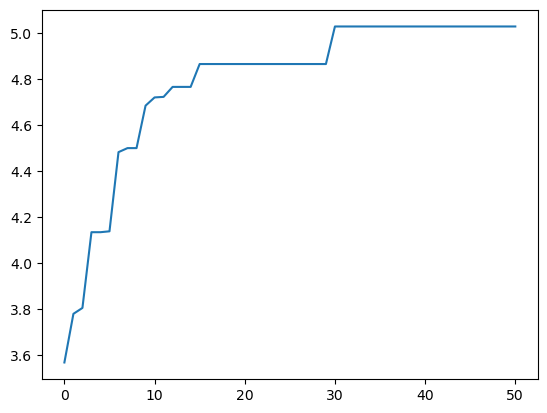

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.027211336529438
Flight 25 in Sleeve 7 - Flight 16 in Sleeve 8 - Flight 3 in Zone 2 - Flight 28 in Zone 9 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 5 - Flight 19 in Sleeve 3 - Flight 6 in Sleeve 6 - Flight 7 in Sleeve 1 - Flight 13 in Zone 0

Poblacion inicial, best_fitness = 3.9718168221941976
generacion 0, (Mejor fitness = 3.9718168221941976)
generacion 10, (Mejor fitness = 4.598605891664253)
generacion 20, (Mejor fitness = 4.7765727920665855)
generacion 30, (Mejor fitness = 4.807058194979363)
generacion 40, (Mejor fitness = 4.985707552568651)


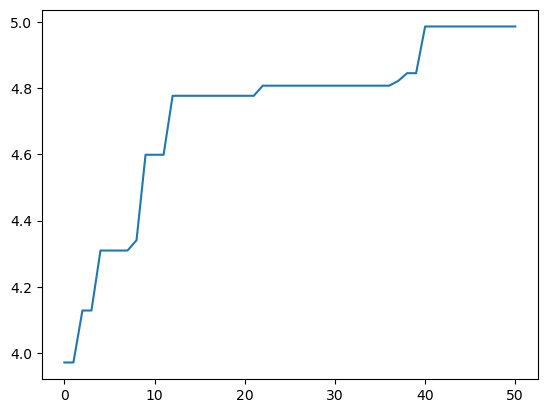

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.985707552568651
Flight 18 in Sleeve 5 - Flight 20 in Sleeve 8 - Flight 28 in Zone 2 - Flight 13 in Zone 0 - Flight 16 in Sleeve 3 - Flight 4 in Sleeve 1 - Flight 25 in Sleeve 7 - Flight 9 in Sleeve 4 - Flight 7 in Sleeve 6 - Flight 3 in Zone 9

Poblacion inicial, best_fitness = 3.6177912408777275
generacion 0, (Mejor fitness = 3.895700895589026)
generacion 10, (Mejor fitness = 4.652665505158865)
generacion 20, (Mejor fitness = 4.712237825791301)
generacion 30, (Mejor fitness = 4.825259348781912)
generacion 40, (Mejor fitness = 4.94500670322178)


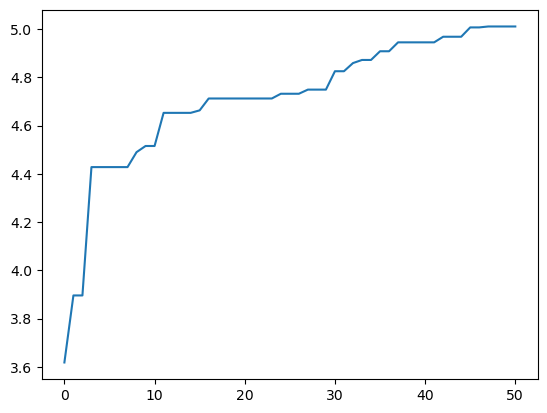

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.010793669895227
Flight 9 in Sleeve 1 - Flight 4 in Sleeve 4 - Flight 25 in Sleeve 8 - Flight 13 in Zone 0 - Flight 6 in Sleeve 5 - Flight 7 in Sleeve 6 - Flight 18 in Sleeve 7 - Flight 24 in Sleeve 3 - Flight 28 in Zone 9 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.5151621827092545
generacion 0, (Mejor fitness = 3.5151621827092545)
generacion 10, (Mejor fitness = 4.498438626275832)
generacion 20, (Mejor fitness = 4.809636357298154)
generacion 30, (Mejor fitness = 4.823836567053911)
generacion 40, (Mejor fitness = 4.867872251720474)


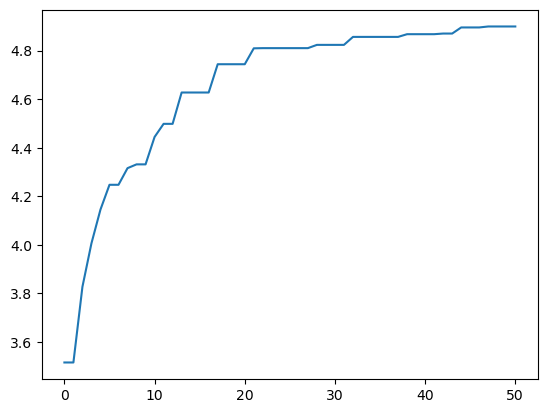

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.899647840087194
Flight 28 in Zone 9 - Flight 3 in Zone 0 - Flight 9 in Sleeve 1 - Flight 7 in Sleeve 6 - Flight 17 in Sleeve 8 - Flight 27 in Sleeve 3 - Flight 6 in Sleeve 7 - Flight 4 in Sleeve 4 - Flight 13 in Zone 2 - Flight 19 in Sleeve 5

Poblacion inicial, best_fitness = 3.5301023834993086
generacion 0, (Mejor fitness = 3.7195855001835527)
generacion 10, (Mejor fitness = 4.513258339082111)
generacion 20, (Mejor fitness = 4.779103766010011)
generacion 30, (Mejor fitness = 4.891055224072932)
generacion 40, (Mejor fitness = 4.921364406532523)


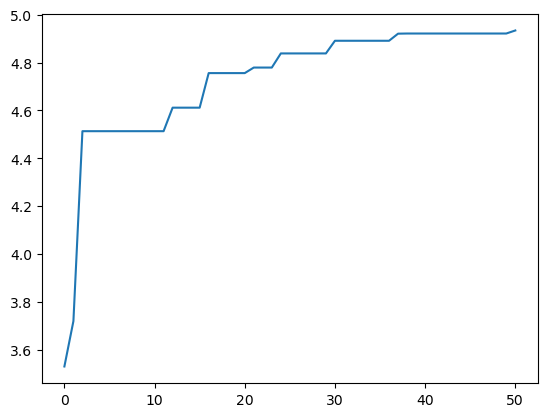

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.934044303544105
Flight 9 in Sleeve 3 - Flight 18 in Sleeve 7 - Flight 13 in Zone 0 - Flight 7 in Sleeve 1 - Flight 17 in Sleeve 6 - Flight 28 in Zone 9 - Flight 6 in Sleeve 8 - Flight 19 in Sleeve 5 - Flight 3 in Zone 2 - Flight 4 in Sleeve 4

Poblacion inicial, best_fitness = 3.5961635977017004
generacion 0, (Mejor fitness = 3.5961635977017004)
generacion 10, (Mejor fitness = 4.506144152055123)
generacion 20, (Mejor fitness = 4.710791457966798)
generacion 30, (Mejor fitness = 4.774491797109673)
generacion 40, (Mejor fitness = 4.804710040158519)


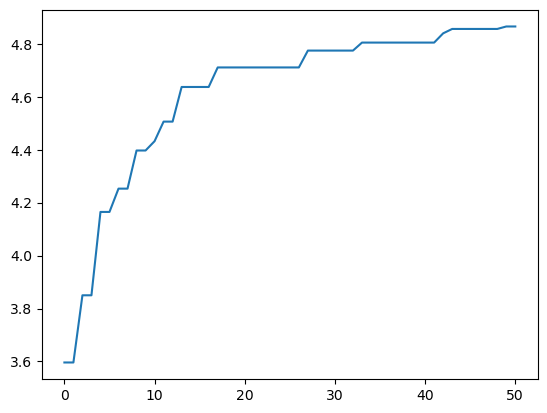

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.865554788615555
Flight 4 in Sleeve 4 - Flight 9 in Sleeve 6 - Flight 13 in Zone 2 - Flight 16 in Sleeve 8 - Flight 7 in Sleeve 1 - Flight 25 in Sleeve 7 - Flight 20 in Zone 0 - Flight 28 in Zone 9 - Flight 12 in Sleeve 3 - Flight 18 in Sleeve 5

Poblacion inicial, best_fitness = 3.9845222711480033
generacion 0, (Mejor fitness = 3.9845222711480033)
generacion 10, (Mejor fitness = 4.671192178871654)
generacion 20, (Mejor fitness = 4.724343501087324)
generacion 30, (Mejor fitness = 4.823046651409791)
generacion 40, (Mejor fitness = 4.86038885871665)


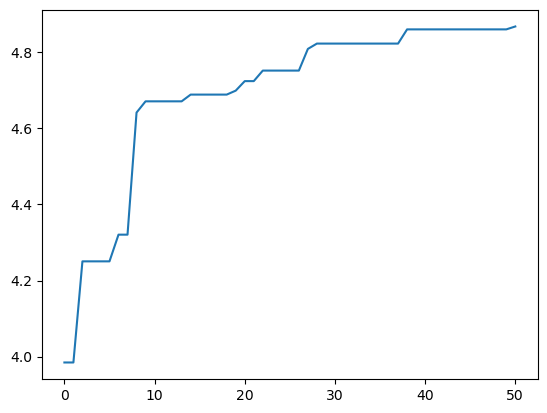

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.868018664321595
Flight 12 in Sleeve 8 - Flight 13 in Zone 0 - Flight 16 in Sleeve 3 - Flight 18 in Sleeve 7 - Flight 25 in Sleeve 6 - Flight 28 in Zone 9 - Flight 7 in Sleeve 4 - Flight 17 in Sleeve 5 - Flight 19 in Sleeve 1 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.7039944511558
generacion 0, (Mejor fitness = 3.7039944511558)
generacion 10, (Mejor fitness = 4.698397529225992)
generacion 20, (Mejor fitness = 4.7757708577181495)
generacion 30, (Mejor fitness = 4.926143165940916)
generacion 40, (Mejor fitness = 4.966189524832442)


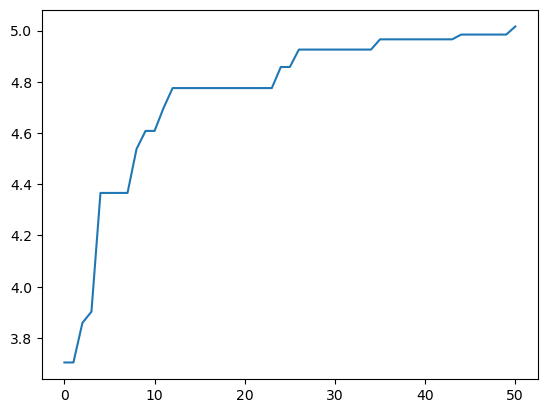

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 5.016386658207091
Flight 28 in Zone 9 - Flight 4 in Sleeve 1 - Flight 17 in Sleeve 8 - Flight 13 in Zone 0 - Flight 3 in Zone 2 - Flight 18 in Sleeve 5 - Flight 9 in Sleeve 4 - Flight 19 in Sleeve 3 - Flight 7 in Sleeve 6 - Flight 25 in Sleeve 7

Poblacion inicial, best_fitness = 3.863953613486002
generacion 0, (Mejor fitness = 4.031036104699126)
generacion 10, (Mejor fitness = 4.455073813367941)
generacion 20, (Mejor fitness = 4.792849826861)
generacion 30, (Mejor fitness = 4.938368086360261)
generacion 40, (Mejor fitness = 4.938368086360261)


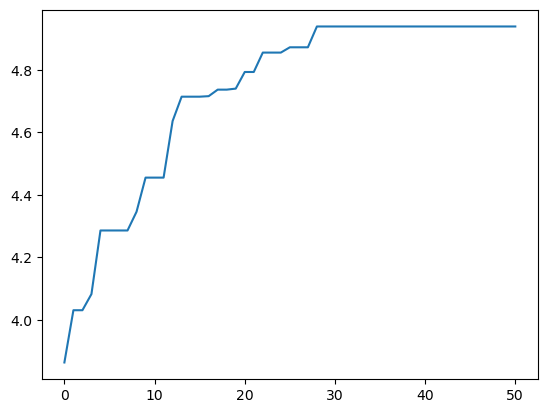

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.938368086360261
Flight 6 in Sleeve 3 - Flight 7 in Sleeve 6 - Flight 25 in Sleeve 7 - Flight 28 in Zone 9 - Flight 17 in Sleeve 8 - Flight 16 in Sleeve 5 - Flight 3 in Zone 2 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 20 in Zone 0

Poblacion inicial, best_fitness = 3.4756357510989906
generacion 0, (Mejor fitness = 3.4756357510989906)
generacion 10, (Mejor fitness = 4.323552194875818)
generacion 20, (Mejor fitness = 4.68302524286315)
generacion 30, (Mejor fitness = 4.703559218809374)
generacion 40, (Mejor fitness = 4.76599736144272)


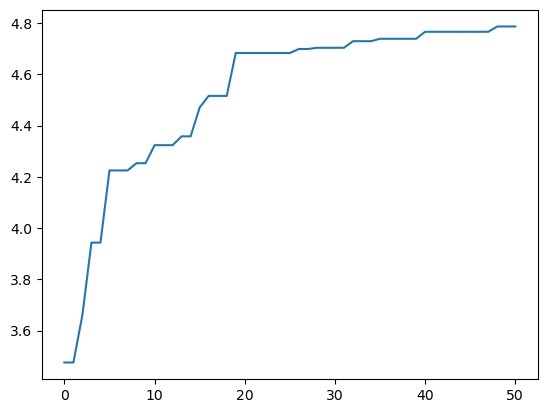

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.786699160839259
Flight 1 in Sleeve 5 - Flight 10 in Sleeve 3 - Flight 28 in Zone 9 - Flight 7 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 3 in Zone 2 - Flight 25 in Sleeve 7 - Flight 9 in Sleeve 1 - Flight 16 in Sleeve 8 - Flight 18 in Zone 0



In [30]:
experimentacion("Codigo con crossover order_permutation y mutation swap tasa 0.5", "roulette", "crossover_orderpermutation", "swap", p_mut=0.5)

### Codigo con crossover order_permutation y mutation swap tasa 0.9

Poblacion inicial, best_fitness = 3.4710250928475914
generacion 0, (Mejor fitness = 3.4710250928475914)
generacion 10, (Mejor fitness = 4.421184900968079)
generacion 20, (Mejor fitness = 4.8528690650907365)
generacion 30, (Mejor fitness = 4.8528690650907365)
generacion 40, (Mejor fitness = 4.951765772622615)


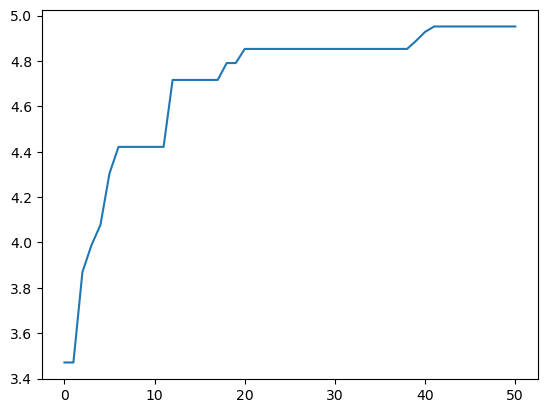

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.951765772622615
Flight 25 in Sleeve 7 - Flight 3 in Zone 9 - Flight 13 in Zone 0 - Flight 4 in Sleeve 4 - Flight 19 in Sleeve 8 - Flight 28 in Zone 2 - Flight 9 in Sleeve 5 - Flight 7 in Sleeve 6 - Flight 18 in Sleeve 1 - Flight 6 in Sleeve 3

Poblacion inicial, best_fitness = 3.8534215360303774
generacion 0, (Mejor fitness = 3.8534215360303774)
generacion 10, (Mejor fitness = 4.797904224007394)
generacion 20, (Mejor fitness = 4.797904224007394)
generacion 30, (Mejor fitness = 4.843480227953236)
generacion 40, (Mejor fitness = 4.843480227953236)


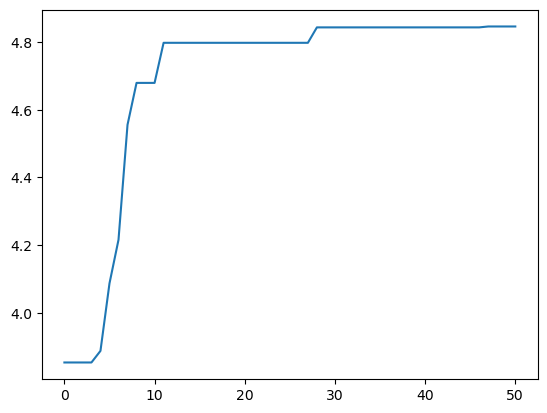

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.846154853313066
Flight 7 in Sleeve 1 - Flight 28 in Zone 9 - Flight 24 in Sleeve 7 - Flight 19 in Sleeve 6 - Flight 9 in Sleeve 5 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 8 - Flight 20 in Sleeve 3 - Flight 3 in Zone 0 - Flight 13 in Zone 2

Poblacion inicial, best_fitness = 3.411995444219956
generacion 0, (Mejor fitness = 3.411995444219956)
generacion 10, (Mejor fitness = 4.575450722442323)
generacion 20, (Mejor fitness = 4.869263183109043)
generacion 30, (Mejor fitness = 4.929217121277469)
generacion 40, (Mejor fitness = 4.929217121277469)


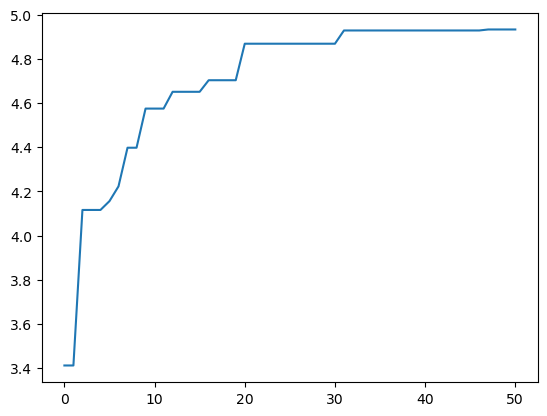

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.9337317636703455
Flight 9 in Sleeve 1 - Flight 13 in Zone 9 - Flight 6 in Sleeve 8 - Flight 16 in Sleeve 3 - Flight 28 in Zone 2 - Flight 10 in Sleeve 7 - Flight 18 in Sleeve 6 - Flight 3 in Zone 0 - Flight 4 in Sleeve 4 - Flight 7 in Sleeve 5

Poblacion inicial, best_fitness = 3.9871962437510895
generacion 0, (Mejor fitness = 3.9871962437510895)
generacion 10, (Mejor fitness = 4.717910039289015)
generacion 20, (Mejor fitness = 4.798049935263599)
generacion 30, (Mejor fitness = 4.872508754859702)
generacion 40, (Mejor fitness = 4.993501173256018)


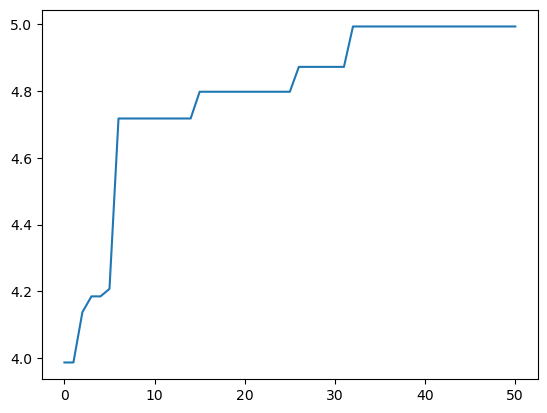

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.993501173256018
Flight 19 in Sleeve 8 - Flight 6 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 3 - Flight 25 in Sleeve 5 - Flight 28 in Zone 9 - Flight 7 in Sleeve 1 - Flight 13 in Zone 0 - Flight 16 in Sleeve 7 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.505381119013339
generacion 0, (Mejor fitness = 3.575765037790832)
generacion 10, (Mejor fitness = 4.510788568269179)
generacion 20, (Mejor fitness = 4.767247732165805)
generacion 30, (Mejor fitness = 4.8115421727247485)
generacion 40, (Mejor fitness = 4.853815611227904)


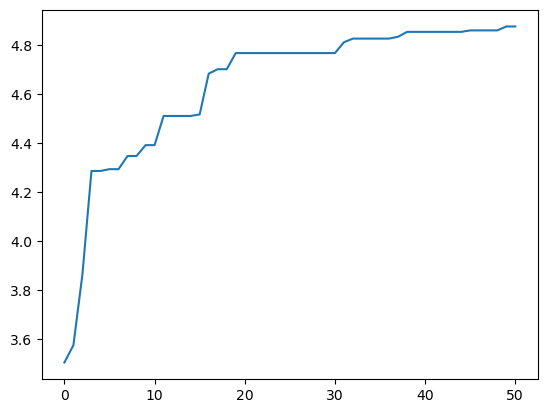

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.875787195436451
Flight 4 in Sleeve 1 - Flight 25 in Sleeve 6 - Flight 6 in Sleeve 3 - Flight 21 in Sleeve 8 - Flight 19 in Sleeve 7 - Flight 3 in Zone 2 - Flight 13 in Zone 0 - Flight 7 in Sleeve 5 - Flight 28 in Zone 9 - Flight 9 in Sleeve 4

Poblacion inicial, best_fitness = 3.5719384195268447
generacion 0, (Mejor fitness = 4.078573188707684)
generacion 10, (Mejor fitness = 4.673192939306295)
generacion 20, (Mejor fitness = 4.7970032121555715)
generacion 30, (Mejor fitness = 4.833368514866085)
generacion 40, (Mejor fitness = 4.8789138072817675)


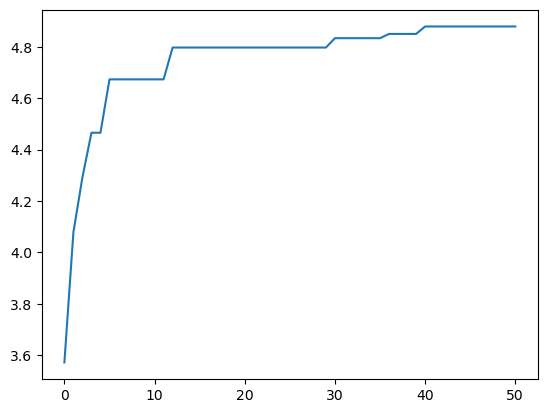

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.8789138072817675
Flight 28 in Zone 2 - Flight 6 in Sleeve 7 - Flight 20 in Zone 0 - Flight 4 in Sleeve 1 - Flight 24 in Sleeve 3 - Flight 18 in Sleeve 6 - Flight 3 in Zone 9 - Flight 7 in Sleeve 5 - Flight 9 in Sleeve 4 - Flight 16 in Sleeve 8

Poblacion inicial, best_fitness = 3.916951657878154
generacion 0, (Mejor fitness = 4.146860744030788)
generacion 10, (Mejor fitness = 4.661441503347085)
generacion 20, (Mejor fitness = 4.7664913084639275)
generacion 30, (Mejor fitness = 4.866351770704033)
generacion 40, (Mejor fitness = 4.953145858786993)


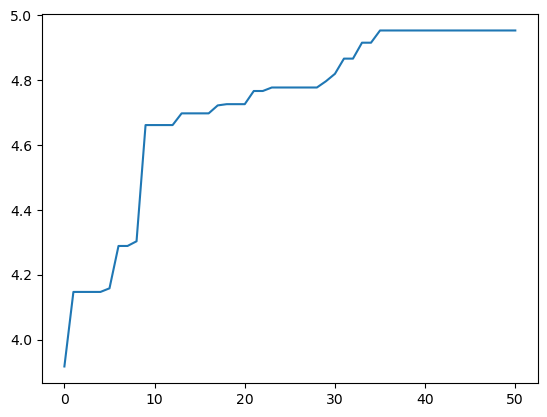

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.953145858786993
Flight 9 in Sleeve 4 - Flight 7 in Sleeve 5 - Flight 28 in Zone 2 - Flight 16 in Sleeve 8 - Flight 13 in Zone 0 - Flight 19 in Sleeve 6 - Flight 4 in Sleeve 1 - Flight 17 in Sleeve 3 - Flight 3 in Zone 9 - Flight 25 in Sleeve 7

Poblacion inicial, best_fitness = 4.0537458682674075
generacion 0, (Mejor fitness = 4.0537458682674075)
generacion 10, (Mejor fitness = 4.53172731540705)
generacion 20, (Mejor fitness = 4.709393931426072)
generacion 30, (Mejor fitness = 4.7559445432789635)
generacion 40, (Mejor fitness = 4.85020679930828)


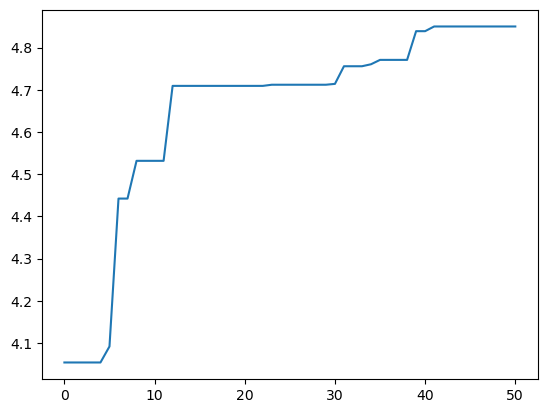

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.85020679930828
Flight 10 in Sleeve 3 - Flight 19 in Sleeve 8 - Flight 28 in Zone 2 - Flight 3 in Zone 9 - Flight 4 in Sleeve 4 - Flight 16 in Sleeve 5 - Flight 6 in Sleeve 7 - Flight 20 in Sleeve 1 - Flight 13 in Zone 0 - Flight 7 in Sleeve 6

Poblacion inicial, best_fitness = 3.5924114318863847
generacion 0, (Mejor fitness = 3.8190276577674203)
generacion 10, (Mejor fitness = 4.658175705401186)
generacion 20, (Mejor fitness = 4.776066551587622)
generacion 30, (Mejor fitness = 4.829965283486065)
generacion 40, (Mejor fitness = 4.920623129057671)


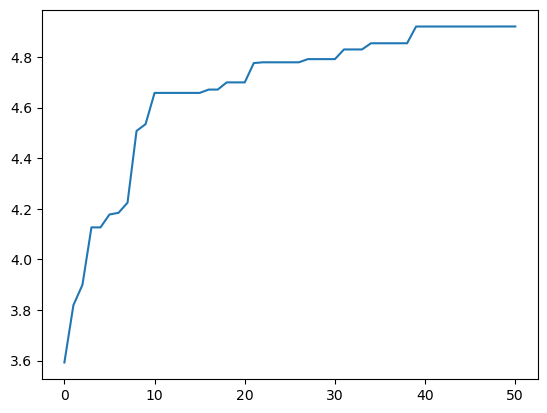

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.920797252732824
Flight 6 in Sleeve 6 - Flight 20 in Sleeve 5 - Flight 16 in Sleeve 3 - Flight 19 in Sleeve 8 - Flight 28 in Zone 9 - Flight 13 in Zone 0 - Flight 3 in Zone 2 - Flight 7 in Sleeve 1 - Flight 18 in Sleeve 7 - Flight 4 in Sleeve 4

Poblacion inicial, best_fitness = 3.4529203892018345
generacion 0, (Mejor fitness = 3.5336571838939235)
generacion 10, (Mejor fitness = 4.490310571136639)
generacion 20, (Mejor fitness = 4.77444539355231)
generacion 30, (Mejor fitness = 4.822274258752028)
generacion 40, (Mejor fitness = 4.95791340941911)


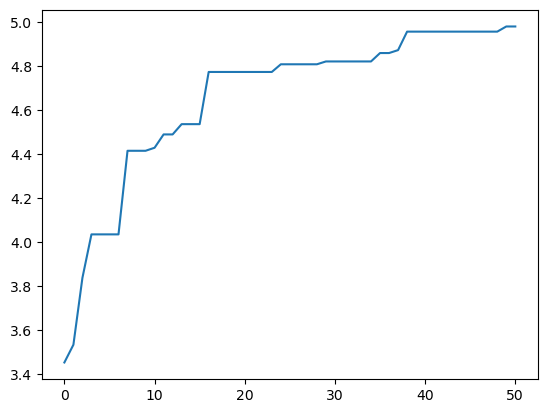

Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.981355077422244
Flight 19 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 18 in Sleeve 7 - Flight 3 in Zone 2 - Flight 16 in Sleeve 8 - Flight 25 in Sleeve 5 - Flight 13 in Zone 0 - Flight 28 in Zone 9 - Flight 7 in Sleeve 4 - Flight 6 in Sleeve 3



In [31]:
experimentacion("Codigo con crossover order_permutation y mutation swap tasa 0.9", "roulette", "crossover_orderpermutation", "swap", p_mut=0.9)

### Dataframe Resultado

In [32]:
df_resultado = pd.DataFrame(rows)
df_resultado

,Tag,Fitness,Selection,Crossover,Mutation,Pmut,Asignacion
0,Codigo con crossover uniform y mutation position,4.409001,roulette,uniform,position,0.7,Flight 4 in Sleeve 1 - Flight 7 in Sleeve 5 - ...
1,Codigo con crossover uniform y mutation position,4.235599,roulette,uniform,position,0.7,Flight 17 in Sleeve 1 - Flight 6 in Sleeve 6 -...
2,Codigo con crossover uniform y mutation position,3.681901,roulette,uniform,position,0.7,Flight 22 in Sleeve 3 - Flight 6 in Sleeve 4 -...
3,Codigo con crossover uniform y mutation position,3.810119,roulette,uniform,position,0.7,Flight 24 in Sleeve 8 - Flight 28 in Zone 2 - ...
4,Codigo con crossover uniform y mutation position,3.610074,roulette,uniform,position,0.7,Flight 13 in Sleeve 1 - Flight 11 in Sleeve 8 ...
5,Codigo con crossover uniform y mutation position,3.901483,roulette,uniform,position,0.7,Flight 5 in Zone 9 - Flight 12 in Sleeve 3 - F...
6,Codigo con crossover uniform y mutation position,3.943435,roulette,uniform,position,0.7,Flight 19 in Zone 2 - Flight 21 in Sleeve 6 - ...
7,Codigo con crossover uniform y mutation position,3.947819,roulette,uniform,position,0.7,Flight 3 in Sleeve 4 - Flight 19 in Zone 0 - F...
8,Codigo con crossover uniform y mutation position,3.971786,roulette,uniform,position,0.7,Flight 11 in Sleeve 7 - Flight 28 in Zone 2 - ...
9,Codigo con crossover uniform y mutation position,4.124120,roulette,uniform,position,0.7,Flight 6 in Sleeve 6 - Flight 3 in Zone 9 - Fl...


In [33]:
df_resultado.sort_values(['Fitness','Crossover','Mutation','Pmut'], ascending=[True, True, True, True])

,Tag,Fitness,Selection,Crossover,Mutation,Pmut,Asignacion
4,Codigo con crossover uniform y mutation position,3.610074,roulette,uniform,position,0.7,Flight 13 in Sleeve 1 - Flight 11 in Sleeve 8 ...
2,Codigo con crossover uniform y mutation position,3.681901,roulette,uniform,position,0.7,Flight 22 in Sleeve 3 - Flight 6 in Sleeve 4 -...
3,Codigo con crossover uniform y mutation position,3.810119,roulette,uniform,position,0.7,Flight 24 in Sleeve 8 - Flight 28 in Zone 2 - ...
5,Codigo con crossover uniform y mutation position,3.901483,roulette,uniform,position,0.7,Flight 5 in Zone 9 - Flight 12 in Sleeve 3 - F...
6,Codigo con crossover uniform y mutation position,3.943435,roulette,uniform,position,0.7,Flight 19 in Zone 2 - Flight 21 in Sleeve 6 - ...
7,Codigo con crossover uniform y mutation position,3.947819,roulette,uniform,position,0.7,Flight 3 in Sleeve 4 - Flight 19 in Zone 0 - F...
8,Codigo con crossover uniform y mutation position,3.971786,roulette,uniform,position,0.7,Flight 11 in Sleeve 7 - Flight 28 in Zone 2 - ...
9,Codigo con crossover uniform y mutation position,4.124120,roulette,uniform,position,0.7,Flight 6 in Sleeve 6 - Flight 3 in Zone 9 - Fl...
1,Codigo con crossover uniform y mutation position,4.235599,roulette,uniform,position,0.7,Flight 17 in Sleeve 1 - Flight 6 in Sleeve 6 -...
0,Codigo con crossover uniform y mutation position,4.409001,roulette,uniform,position,0.7,Flight 4 in Sleeve 1 - Flight 7 in Sleeve 5 - ...


In [34]:
df_resultado.groupby(['Crossover','Mutation','Pmut'], as_index=False)[['Fitness']].mean().sort_values(by='Fitness', ascending=False)

,Crossover,Mutation,Pmut,Fitness
1,crossover_orderpermutation,swap,0.1,4.976233
3,crossover_orderpermutation,swap,0.7,4.957068
0,crossover_orderpermutation,swap,0.0,4.945522
2,crossover_orderpermutation,swap,0.5,4.933243
4,crossover_orderpermutation,swap,0.9,4.918536
5,uniform,position,0.7,3.963534


In [35]:
df_resultado.groupby(['Crossover','Mutation','Pmut'], as_index=False)['Fitness'].max().sort_values(by='Fitness', ascending=False)


,Crossover,Mutation,Pmut,Fitness
1,crossover_orderpermutation,swap,0.1,5.054550
0,crossover_orderpermutation,swap,0.0,5.051267
3,crossover_orderpermutation,swap,0.7,5.029166
2,crossover_orderpermutation,swap,0.5,5.027211
4,crossover_orderpermutation,swap,0.9,4.993501
5,uniform,position,0.7,4.409001


## <b>Paso 6</b>

#### build_offspring_population

In [36]:
def build_offspring_population(population, crossover, mutation, p_mut):     
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento 
    
    mating_pool = []
    for i in range(int(pop_size/2)): 
        # escoje dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) ) 
        
    ## Crea la poblacion descendencia cruzando las parejas del mating pool 
    offspring_population = []
    for i in range(len(mating_pool)):
      
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      elif crossover == "crossover_orderpermutation":
        offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
      
      else:
        raise NotImplementedError
    
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        elif mutation == "inversion":
          offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
        elif mutation == "flip":
          offspring_population[i] = offspring_population[i].mutation_flip() # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
        elif mutation == "swap":
          offspring_population[i] = offspring_population[i].mutation_swap() # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
        else:
          raise NotImplementedError    
                
    return offspring_population

#### get_crowding_distances

In [37]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

#### select_by_crowding

In [38]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

#### get_paretofront_population

In [39]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0 
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

#### build_next_population

In [40]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    next_population = []
    
    while len(next_population) < min_pop_size:  # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding(paretofront_population, max_pop_size - len(next_population))
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend(paretofront_population)
    
        # remueve de population los individuos que fueron agregados a next_population
        for selected_individual in paretofront_population:
            population = [individual for individual in population if not (individual.gates == selected_individual.gates and individual.flights == selected_individual.flights)]
                    
    return next_population

#### Clases Flight y Gate

In [41]:
# Clase para representar vuelos
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs  
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto

# Clase para representar gates
class Gate(object):
    def __init__(self, identifier, distance, potential_of_speed, number_of_persons_every_10m):
        self.identifier = identifier
        self.distance = distance
        self.potential_of_speed = potential_of_speed
        self.number_of_persons_every_10m = number_of_persons_every_10m

#### fitness_ngsaii

In [42]:
def fitness_ngsaii(flights, gates):
    grace_time = 5/100
    fitness = np.zeros(2)
    total_passengers = 0  # Total de pasajeros para todos los vuelos
    total_disembarkation_time = 0  # Tiempo total de desembarco

    for flight, gate in zip(flights, gates):
        # Añade el número de pasajeros del vuelo al total
        total_passengers += flight.number_of_passengers
        
        # Calcula el tiempo de desembarco para el vuelo y el gate actuales
        if isinstance(gate, Sleeve):  # si el gate es de tipo Manga 
            disembarkation_time = ((flight.number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) 
                                   + flight.parking_time + flight.inspection_time) * (1 + grace_time)
        else:  # si el gate es de tipo Zona
            disembarkation_time = ((flight.number_of_passengers * gate.distance / process_flow(gate)) 
                                   + flight.parking_time + (flight.landing_time_on_stairs * flight.number_of_passengers / flight.maximum_capacity) 
                                   + flight.inspection_time) * (1 + grace_time)
        
        # Suma el tiempo de desembarco del vuelo al tiempo total
        total_disembarkation_time += disembarkation_time

    # Retorna el número total de pasajeros y el tiempo total de desembarco como una tupla
    # Si quieres incluir la eficiencia acumulada como un tercer objetivo, puedes agregarla al retorno: 
    # return total_passengers, total_disembarkation_time, cumulative_efficiency
    fitness[0] = total_passengers
    fitness[1] = total_disembarkation_time
    return fitness

# La función 'evaluate_population_ngsaii' debería ahora trabajar con esta nueva definición de la función de fitness:
def evaluate_population_ngsaii(population, fitness_fn ):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    population_size = len(population)
    for i in range(population_size):
        if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].flights, population[i].gates)


#### init_population_ngsaii

In [43]:
from random import shuffle

In [44]:

def init_population_ngsaii(population_number,flights_to_assign, list_of_flights, list_of_gates):
    """
    Inicializa una población para el algoritmo genético.
    
    :param population_number: Número de individuos en la población
    :param list_of_flights: Lista de todos los vuelos disponibles
    :param list_of_gates: Lista de todas las puertas disponibles
    :return: Lista de individuos de la población inicial
    """
    population = []
    for _ in range(population_number):
        
        if flights_to_assign > len(list_of_flights) or flights_to_assign > len(list_of_gates):
            raise ValueError("No hay suficientes vuelos o puertas para asignar a cada individuo.")
        # Copia las listas de vuelos y puertas
        shuffled_flights = list_of_flights[:]
        shuffled_gates = list_of_gates[:]
        
        # Mezclar aleatoriamente las listas
        shuffle(shuffled_flights)
        shuffle(shuffled_gates)
        
        # Asignar cada vuelo a una puerta
        # Si hay más vuelos que puertas, algunos vuelos pueden no ser asignados
        flights_to_gates_assignment = list(zip(shuffled_flights, shuffled_gates[:len(shuffled_flights)]))
        
        # Separa los vuelos y las puertas de nuevo para crear un nuevo individuo
        flights, gates = zip(*flights_to_gates_assignment)
        individual = Individual(flights=flights, gates=gates, flights_pool=list_of_flights, gates_pool=list_of_gates)
        population.append(individual)

    return population



#### algoritmo_multiobjetivo

In [45]:
import random


In [57]:
def algoritmo_multiobjetivo(MIN_POP_SIZE = 100,  # Tamaño mínimo de la población
        MAX_POP_SIZE = 100,  # Tamaño máximo de la población
        GENERATIONS = 300,   # Número de generaciones
        PMUT = 0.5,
        crossover = "crossover_orderpermutation",
        mutation = "swap"):

    ## Hiperparámetros del algoritmo genético ajustados para el problema de vuelos y gates
    # Número de vuelos
    NUM_GATES = 10         # Número de gates
    # Asumiendo que los rangos de capacidad y número de pasajeros son conocidos
    MAX_CAPACITY = 180     # Máxima capacidad de un vuelo
    MIN_CAPACITY = 100     # Mínima capacidad de un vuelo
    MAX_PASSENGERS = 170   # Máximo número de pasajeros en un vuelo
    MIN_PASSENGERS = 90    # Mínimo número de pasajeros en un vuelo


    # Suponiendo que tienes una cantidad predefinida de vuelos y rangos para cada uno de los atributos
    NUM_FLIGHTS = 30  # Número de vuelos

    # Rangos para los atributos de los vuelos
    MAX_CAPACITY_RANGE = (100, 300)  # Capacidad máxima del vuelo (min, max)
    NUMBER_OF_PASSENGERS_RANGE = (50, 290)  # Número de pasajeros (min, max)
    PARKING_TIME_RANGE = (5, 20)  # Tiempo de parqueo (min, max)
    LENGTH_WINGS_RANGE = (20, 60)  # Longitud de las alas (min, max)
    INSPECTION_TIME_RANGE = (10, 30)  # Tiempo de inspección (min, max)
    LANDING_TIME_ON_STAIRS_RANGE = (5, 15)  # Tiempo de aterrizaje en escaleras (min, max)
    ARRIVING_TIME_RANGE = (10, 50)  # Tiempo de llegada al aeropuerto (min, max)
    LEAVING_TIME_RANGE = (10, 50)  # Tiempo de partida del aeropuerto (min, max)

    # Hiperparámetros del algoritmo genético
            # Tasa de mutación

    # Función para generar un vuelo aleatorio
    def generate_random_flight(identifier):
        return Flight(
            identifier=identifier,
            maximum_capacity=random.randint(*MAX_CAPACITY_RANGE),
            number_of_passengers=random.randint(*NUMBER_OF_PASSENGERS_RANGE),
            parking_time=random.randint(*PARKING_TIME_RANGE),
            length_wings=random.randint(*LENGTH_WINGS_RANGE),
            inspection_time=random.randint(*INSPECTION_TIME_RANGE),
            landing_time_on_stairs=random.randint(*LANDING_TIME_ON_STAIRS_RANGE),
            arriving_time=random.randint(*ARRIVING_TIME_RANGE),
            leaving_time=random.randint(*LEAVING_TIME_RANGE)
        )

    # Generar pool de vuelos
    flights_pool = [generate_random_flight(i) for i in range(NUM_FLIGHTS)]
    gates_pool = [Gate(i, randint(1, 10), randint(1, 3), randint(10, 30)) for i in range(NUM_GATES)]

    
    flights_to_assign = NUM_FLIGHTS if NUM_FLIGHTS <= NUM_GATES	else NUM_GATES
    # Crea una población inicial basada en vuelos y gates
    poblacion_inicial = init_population_ngsaii(MAX_POP_SIZE, flights_to_assign, flights_pool, gates_pool)

    # ... Resto del código NSGA-II ...
    ## Código principal del algoritmo genético NSGA-II

    P = deepcopy(poblacion_inicial)  # copia la población inicial en una nueva variable para no alterar la población inicial

    # Evalúa la población inicial
    evaluate_population_ngsaii(P, fitness_ngsaii)  

    ## Ejecuta los ciclos evolutivos 
    for g in range(GENERATIONS):   # Por cada generación
        
        if g % 10 == 0:
            print('Generación {} (de {})'.format(g, GENERATIONS))
        
        ## Genera y evalúa la población hija    
        Q = build_offspring_population(P, crossover, mutation, PMUT)
        evaluate_population_ngsaii(Q,fitness_ngsaii)
        
        ## Une la población padre y la población hija
        P.extend(Q) 
        
        ## Construye la población de la siguiente generación
        P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

    # Obtiene la población de la frontera de Pareto final 
    return get_paretofront_population(P)


In [58]:
pareto_front_population = algoritmo_multiobjetivo()

Generación 0 (de 300)
Generación 10 (de 300)
Generación 20 (de 300)
Generación 30 (de 300)
Generación 40 (de 300)
Generación 50 (de 300)
Generación 60 (de 300)
Generación 70 (de 300)
Generación 80 (de 300)
Generación 90 (de 300)
Generación 100 (de 300)
Generación 110 (de 300)
Generación 120 (de 300)
Generación 130 (de 300)
Generación 140 (de 300)
Generación 150 (de 300)
Generación 160 (de 300)
Generación 170 (de 300)
Generación 180 (de 300)
Generación 190 (de 300)
Generación 200 (de 300)
Generación 210 (de 300)
Generación 220 (de 300)
Generación 230 (de 300)
Generación 240 (de 300)
Generación 250 (de 300)
Generación 260 (de 300)
Generación 270 (de 300)
Generación 280 (de 300)
Generación 290 (de 300)


In [59]:
for i, ind in enumerate(pareto_front_population):
    print(f"Individuo {i}: Fitness - {ind.fitness}")

Individuo 0: Fitness - [2379.          945.13039426]
Individuo 1: Fitness - [2135.         1009.10754256]
Individuo 2: Fitness - [2195.        1004.9566588]
Individuo 3: Fitness - [2227.          988.30456498]
Individuo 4: Fitness - [2195.        1004.9566588]
Individuo 5: Fitness - [2303.          969.66596038]
Individuo 6: Fitness - [2135.         1009.10754256]
Individuo 7: Fitness - [2135.         1009.10754256]
Individuo 8: Fitness - [2135.         1009.10754256]
Individuo 9: Fitness - [2075.         1009.89034941]
Individuo 10: Fitness - [2135.         1009.10754256]
Individuo 11: Fitness - [2135.         1009.10754256]
Individuo 12: Fitness - [2135.         1009.10754256]
Individuo 13: Fitness - [2135.         1009.10754256]
Individuo 14: Fitness - [2135.         1009.10754256]
Individuo 15: Fitness - [2135.         1009.10754256]
Individuo 16: Fitness - [2211.         996.9227858]
Individuo 17: Fitness - [2379.          945.13039426]
Individuo 18: Fitness - [2135.         1009.

#### graficar_algoritmo

In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# Antes de graficar, imprime los valores de fitness para depuración
def graficar_algoritmo(pareto_front_population,fitness_mono = np.array([])):
    for i, ind in enumerate(pareto_front_population):
        print(f"Individuo {i}: Fitness - {ind.fitness}")
    
    # Plotea los individuos de la frontera de Pareto final
    pop_size = len(pareto_front_population)
    num_objectives = len(pareto_front_population[0].fitness)
        
    # Extrae los valores de fitness de la población en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i, :] = pareto_front_population[i].fitness

    # Continuación con la gráfica, si todo está correcto
    #fitnesses = np.array([ind.fitness for ind in pareto_front_population])
    x = fitnesses[:, 0]  # Número total de pasajeros
    y = fitnesses[:, 1]  # Tiempo total de desembarco

    plt.figure(figsize=(10, 6))
    plt.xlabel('Número total de pasajeros')
    plt.ylabel('Tiempo total de desembarco')
    plt.scatter(x, y, c='blue', marker='o', label='Multi-objetivo')
    
    if fitness_mono.any():
        for i in range(pop_size): fitnesses[i, :] = fitness_mono

        # Continuación con la gráfica, si todo está correcto
        #fitnesses = np.array([ind.fitness for ind in pareto_front_population])
        x1 = fitnesses[:, 0]  # Número total de pasajeros
        y1 = fitnesses[:, 1]  
        plt.scatter(x1, y1, c='red', marker='o', label='Mono-objetivo')

    plt.title('Frontera de Pareto')
    plt.legend()
    plt.grid(True)
    plt.show()


Individuo 0: Fitness - [2379.          945.13039426]
Individuo 1: Fitness - [2135.         1009.10754256]
Individuo 2: Fitness - [2195.        1004.9566588]
Individuo 3: Fitness - [2227.          988.30456498]
Individuo 4: Fitness - [2195.        1004.9566588]
Individuo 5: Fitness - [2303.          969.66596038]
Individuo 6: Fitness - [2135.         1009.10754256]
Individuo 7: Fitness - [2135.         1009.10754256]
Individuo 8: Fitness - [2135.         1009.10754256]
Individuo 9: Fitness - [2075.         1009.89034941]
Individuo 10: Fitness - [2135.         1009.10754256]
Individuo 11: Fitness - [2135.         1009.10754256]
Individuo 12: Fitness - [2135.         1009.10754256]
Individuo 13: Fitness - [2135.         1009.10754256]
Individuo 14: Fitness - [2135.         1009.10754256]
Individuo 15: Fitness - [2135.         1009.10754256]
Individuo 16: Fitness - [2211.         996.9227858]
Individuo 17: Fitness - [2379.          945.13039426]
Individuo 18: Fitness - [2135.         1009.

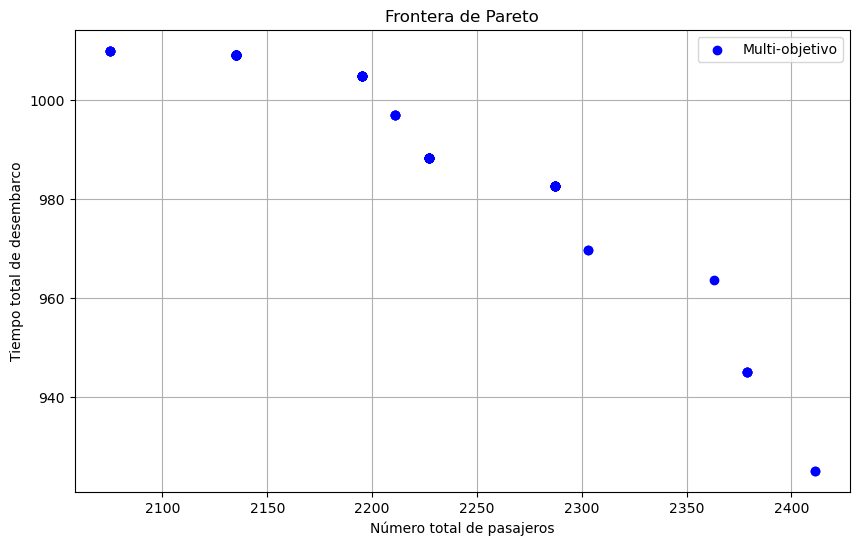

In [60]:
graficar_algoritmo(pareto_front_population)

## <b>Paso 7</b>

### Definiendo Best Indicador Experimentation

In [52]:
# Funcion de experimentacion
def get_bestind_experimentacion(tag, selection_fn="roulette", crossover="uniform", mutation = "position", p_mut = 0.7, reps = 10, num_individuals = 50,n_generations = 50):
    mejor_indicadores = []
    fitness_fn = get_fitness
    best_fitness = 0
    for rep in range(0,reps):
        print ("---------------------------------- " + str(rep+1) +   " ----------------------------------" )
        # Realiza la asignacion con el algoritmo genetico
        best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)
        mejor_indicadores.append({"rep":rep+1,"mejor_indicador":best_ind})
        # muestra la evolucion del mejor fitness
        #plt.plot(bestfitness)
        #plt.show()
        make_solution_report(best_ind,selection_fn,crossover,mutation)
    
    mejor_indicador = max(mejor_indicadores, key=lambda x: x['mejor_indicador'].fitness)
    print("---------------------------------- Repetición "+ str(mejor_indicador['rep']) + " cuyo Best indicator es " + str(mejor_indicador['mejor_indicador'].fitness)+ " ----------------------------------")
    return(mejor_indicador['mejor_indicador'])
    

In [53]:
best_ind = get_bestind_experimentacion("Best Experimento Mono-objetivo", selection_fn="roulette", crossover="crossover_orderpermutation", mutation = "swap", p_mut = 0.1, reps=5,num_individuals = 50,n_generations = 50)

---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.73587416145197
generacion 0, (Mejor fitness = 3.939844509271175)
generacion 10, (Mejor fitness = 4.625402309354239)
generacion 20, (Mejor fitness = 4.738405101036721)
generacion 30, (Mejor fitness = 4.870590798450992)
generacion 40, (Mejor fitness = 4.9492902326433)
Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.959079057085999
Flight 20 in Zone 2 - Flight 12 in Sleeve 3 - Flight 7 in Sleeve 6 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 7 - Flight 28 in Zone 9 - Flight 16 in Sleeve 5 - Flight 9 in Sleeve 1 - Flight 25 in Sleeve 8 - Flight 3 in Zone 0



---------------------------------- 2 ----------------------------------
Poblacion inicial, best_fitness = 3.8324539223539054
generacion 0, (Mejor fitness = 3.8324539223539054)
generacion 10, (Mejor fitness = 4.726456776181948)
generacion 20, (Mejor fitness = 4.896904684501692)
generacion 30, (Mejor fitness = 4.896904684501692)
generacion 40, (Mejor fitness = 4.9596625141368635)
Selection: roulette - Crossover: crossover_orderpermutation - Mutation: swap - Fitness: 4.9596625141368635
Flight 3 in Zone 9 - Flight 18 in Sleeve 3 - Flight 13 in Zone 0 - Flight 20 in Sleeve 8 - Flight 16 in Sleeve 7 - Flight 9 in Sleeve 4 - Flight 28 in Zone 2 - Flight 7 in Sleeve 6 - Flight 4 in Sleeve 1 - Flight 25 in Sleeve 5

---------------------------------- 3 ----------------------------------
Poblacion inicial, best_fitness = 3.5561190320189437
generacion 0, (Mejor fitness = 3.5561190320189437)
generacion 10, (Mejor fitness = 4.554456239571296)
generacion 20, (Mejor fitness = 4.8560067126362)
generac

In [54]:
fitness_mono = fitness_ngsaii(best_ind.flights, best_ind.gates)
print(fitness_mono)

[ 484.         1235.46559929]


#### Definiendo inputs de cada caso

In [55]:
parametros = [
    ## Caso base ##
    {"Caso":"Caso crossover->uniform mut->position pmut->0.7","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0.7, "crossover":"uniform", "mutation":"position"},
    
    ## Caso crossover->crossover_orderpermutation mut->swap ##
    {"Caso":"Caso crossover->crossover_orderpermutation mut->swap pmut->0.7","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0.7, "crossover":"crossover_orderpermutation", "mutation":"swap"},
    {"Caso":"Caso crossover->crossover_orderpermutation mut->swap pmut->0","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0, "crossover":"crossover_orderpermutation", "mutation":"swap"},
    {"Caso":"Caso crossover->crossover_orderpermutation mut->swap pmut->0.1","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0.1, "crossover":"crossover_orderpermutation", "mutation":"swap"},
    {"Caso":"Caso crossover->crossover_orderpermutation mut->swap pmut->0.5","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0.5, "crossover":"crossover_orderpermutation", "mutation":"swap"},
    {"Caso":"Caso crossover->crossover_orderpermutation mut->swap pmut->0.9","MIN_POP_SIZE":50, "MAX_POP_SIZE": 50, "GENERATIONS":100, "PMUT":0.9, "crossover":"crossover_orderpermutation", "mutation":"swap"},
        
    ]

#### Multi-objetivo y Mono-objetivo del caso

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->uniform mut->position pmut->0.7 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)


C:\Users\Sistema\AppData\Local\Temp\ipykernel_28872\2075125236.py:14: RuntimeWarning: invalid value encountered in divide
  normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)


Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->uniform mut->position pmut->0.7 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.191608389208511
generacion 0, (Mejor fitness = 3.191608389208511)
generacion 10, (Mejor fitness = 3.2543007646260405)
generacion 20, (Mejor fitness = 3.2543007646260405)
generacion 30, (Mejor fitness = 3.2543007646260405)
generacion 40, (Mejor fitness = 3.2543007646260405)
generacion 50, (Mejor fitness = 3.5519940249834305)
generacion 60, (Mejor fitness = 3.6739638300497415)
generacion 70, (Mejor fitness = 4.053274555678126)
generacion 80, (Mejor fitness = 4.053274555678126)
generacion 90, (Mejor fitness = 4.053274555678126)
Selecti

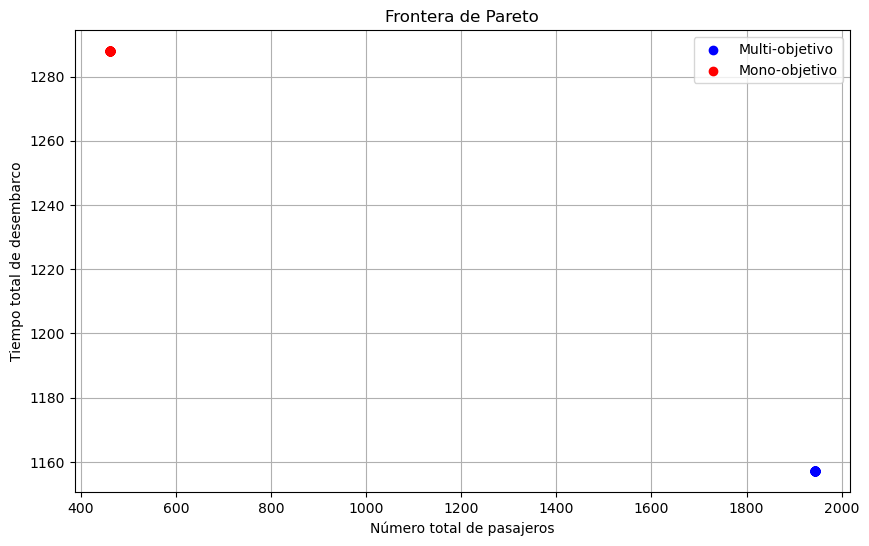

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.7 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)
Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.7 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.797604826867535
generacion 0, (Mejor fitness = 3.797604826867535)
generacion 10, (Mejor fitness = 4.503655060193973)
generacion 20, (Mejor fitness = 4.764848608632395)
generacion 30, (Mejor fitness = 4.912977241355137)
generacion 40, (Mejor fitness = 4.945386884548012)
generacion 50, (Mejor 

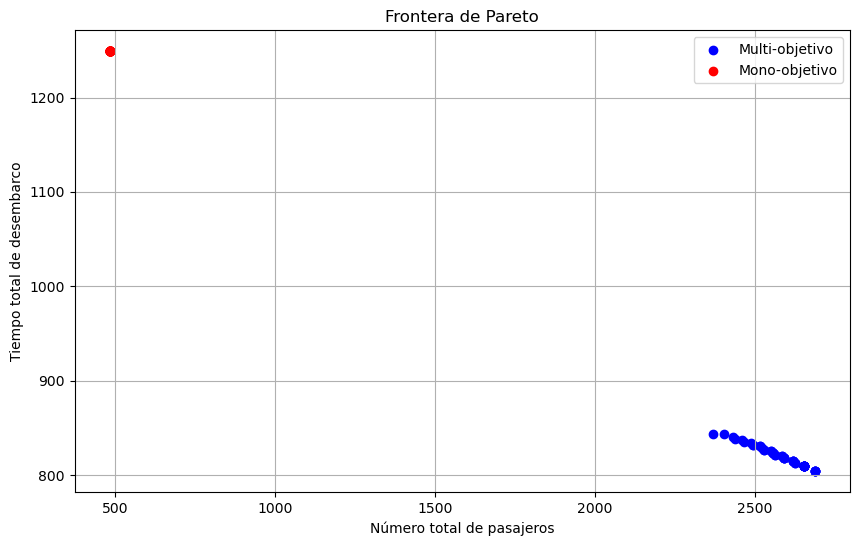

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)
Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 4.177914670814685
generacion 0, (Mejor fitness = 4.177914670814685)
generacion 10, (Mejor fitness = 4.519178148103959)
generacion 20, (Mejor fitness = 4.74809695373539)
generacion 30, (Mejor fitness = 4.8342366647757)
generacion 40, (Mejor fitness = 4.9175141416654675)
generacion 50, (Mejor fitnes

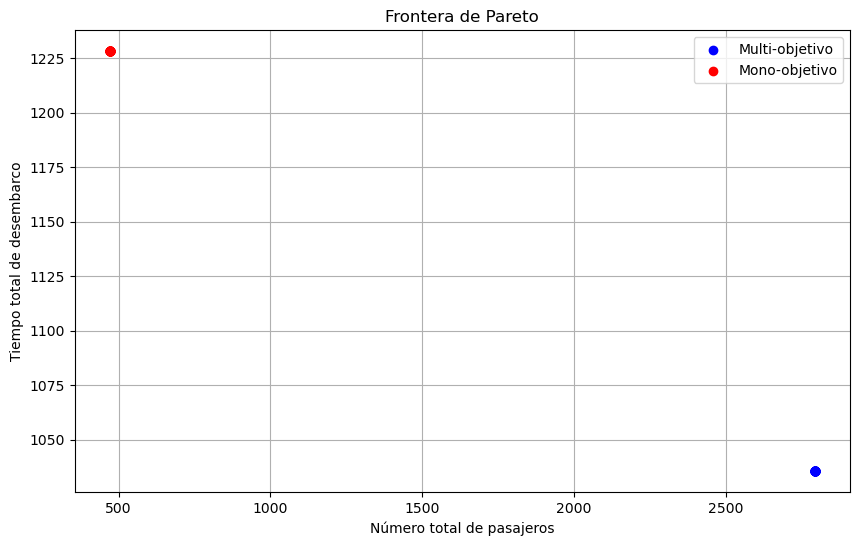

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.1 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)
Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.1 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.4781003747451584
generacion 0, (Mejor fitness = 3.8810891663458693)
generacion 10, (Mejor fitness = 4.524674890133017)
generacion 20, (Mejor fitness = 4.8968019478462335)
generacion 30, (Mejor fitness = 4.952677368688156)
generacion 40, (Mejor fitness = 4.998292006630008)
generacion 50, (Mej

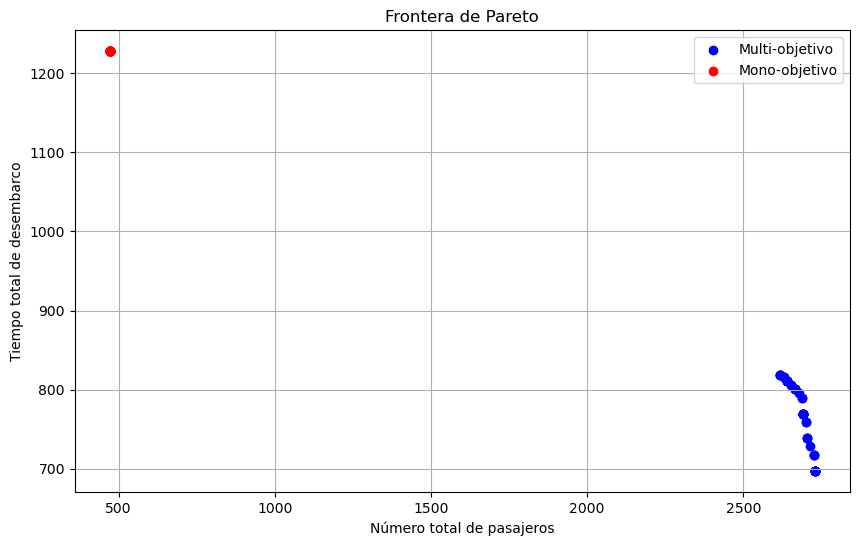

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.5 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)
Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.5 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.71119280541104
generacion 0, (Mejor fitness = 3.8522138555614487)
generacion 10, (Mejor fitness = 4.722494715662731)
generacion 20, (Mejor fitness = 4.87577336202324)
generacion 30, (Mejor fitness = 4.970181675066626)
generacion 40, (Mejor fitness = 4.9866388722919694)
generacion 50, (Mejor 

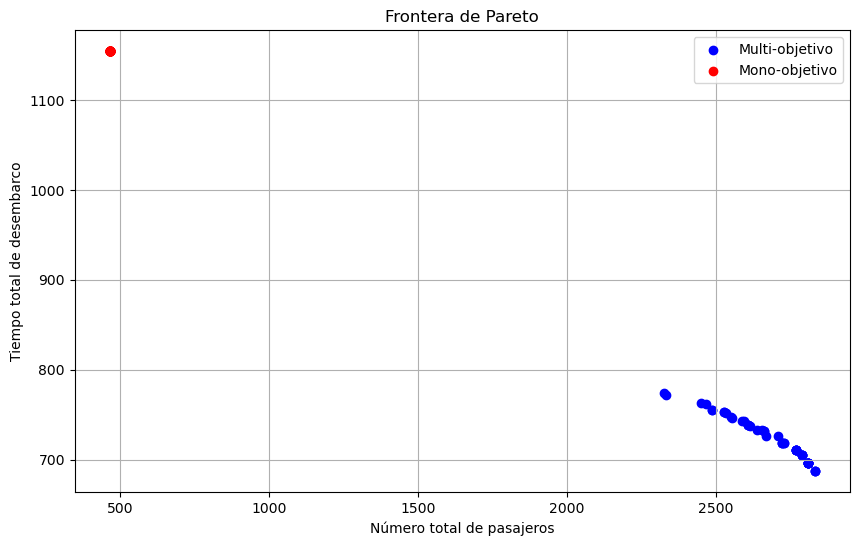

------------------------------------------------ Ejecución Multi-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.9 ------------------------------------------------
Generación 0 (de 100)
Generación 10 (de 100)
Generación 20 (de 100)
Generación 30 (de 100)
Generación 40 (de 100)
Generación 50 (de 100)
Generación 60 (de 100)
Generación 70 (de 100)
Generación 80 (de 100)
Generación 90 (de 100)
------------------------------------------------ Ejecución Mono-Objetivo Caso crossover->crossover_orderpermutation mut->swap pmut->0.9 ------------------------------------------------
---------------------------------- 1 ----------------------------------
Poblacion inicial, best_fitness = 3.971771627105865
generacion 0, (Mejor fitness = 4.032949713507973)
generacion 10, (Mejor fitness = 4.596011049899935)
generacion 20, (Mejor fitness = 4.739751601538461)
generacion 30, (Mejor fitness = 4.822778927758254)
generacion 40, (Mejor fitness = 4.920153971061431)
generacion 50, (Mejor 

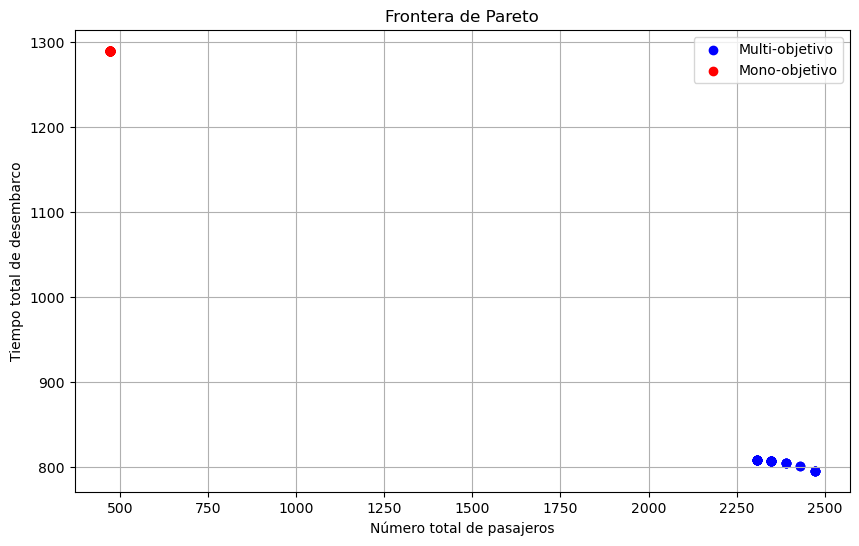

In [56]:
for i in parametros:
    ## Multi-objetivo del caso
    print("------------------------------------------------ Ejecución Multi-Objetivo " + str(i["Caso"]) + " ------------------------------------------------")
    pareto_front_population_Caso1 = algoritmo_multiobjetivo(i["MIN_POP_SIZE"],  i["MAX_POP_SIZE"] ,i["GENERATIONS"], i["PMUT"],i["crossover"],i["mutation"])
    
    ## Mono-objetivo del caso
    print("------------------------------------------------ Ejecución Mono-Objetivo " + str(i["Caso"]) + " ------------------------------------------------")
    best_ind = get_bestind_experimentacion("Experimentación Caso 1", selection_fn="roulette", crossover=i["crossover"],
                                       mutation = i["mutation"], p_mut = i["PMUT"], 
                                       reps=10,num_individuals = i["MAX_POP_SIZE"],n_generations = i["GENERATIONS"])
    
    fitness_mono = fitness_ngsaii(best_ind.flights, best_ind.gates)
    print("---------------------------------- Fitness Mono-Objetivo ----------------------------------")
    print(" # Pasajeros | # Tiempo desembarque")
    print(fitness_mono)

    ## Graficando
    print("------------------------------------------------ Graficando ambos algoritmos ------------------------------------------------")
    print(" # Pasajeros | # Tiempo desembarque")
    graficar_algoritmo(pareto_front_population_Caso1, fitness_mono)